In [1]:
!pip install transformers
!pip install -U d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 909.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: matplotlib-inline

Importing all necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np


import torch
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from d2l import torch as d2l


from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    AdamW
)


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import(
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    cohen_kappa_score,
    roc_curve,
    auc
)


import warnings
warnings.filterwarnings("ignore")

Downloading dataset

In [2]:
train_data_raw = pd.read_csv("/content/drugLibTrain_raw.tsv", delimiter='\t')
test_data_raw = pd.read_csv("/content/drugLibTest_raw.tsv", delimiter='\t')

Невелички аналіз датасету

In [3]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [4]:
train_data_raw.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [5]:
def categorize_rating(rating):
    if rating <= 4:
        return '1-4'
    elif 4 < rating < 7:
        return '5-6'
    else:
        return '7-10'


train_data_raw['rating_category'] = train_data_raw['rating'].apply(categorize_rating)
rating_distribution = train_data_raw['rating_category'].value_counts().sort_index()
print(rating_distribution)

total_count = rating_distribution.sum()
rating_distribution_percent = (rating_distribution / total_count) * 100
print(rating_distribution_percent)

rating_category
1-4      661
5-6      316
7-10    2130
Name: count, dtype: int64
rating_category
1-4     21.274541
5-6     10.170583
7-10    68.554876
Name: count, dtype: float64


Бачимо, що розподіл категорій рейтингу такий як у статті

In [6]:
def categorize_effectiveness_label(rating):
    if rating == 'Ineffective':
        return 0
    elif rating == 'Marginally Effective' or rating == 'Moderately Effective':
        return 1
    elif rating == 'Considerably Effective' or rating == 'Highly Effective':
        return 2


def categorize_sideEffects_label(rating):
    if rating == 'No Side Effects':
        return 0
    elif rating == 'Mild Side Effects' or rating == 'Moderate Side Effects':
        return 1
    elif rating == 'Severe Side Effects' or rating == 'Extremely Severe Side Effects':
        return 2


train_data_raw['effectiveness_category'] = train_data_raw['effectiveness'].apply(categorize_effectiveness_label)
effectiveness_category_distribution = train_data_raw['effectiveness_category'].value_counts().sort_index()

train_data_raw['sideEffects_category'] = train_data_raw['sideEffects'].apply(categorize_sideEffects_label)
sideEffects_category_distribution = train_data_raw['sideEffects_category'].value_counts().sort_index()


print("Розподіл категорій для колонки 'effectiveness':")
print(effectiveness_category_distribution)
print("\nРозподіл категорій для колонки 'sideEffects':")
print(sideEffects_category_distribution)

Розподіл категорій для колонки 'effectiveness':
effectiveness_category
0     247
1     602
2    2258
Name: count, dtype: int64

Розподіл категорій для колонки 'sideEffects':
sideEffects_category
0     930
1    1633
2     544
Name: count, dtype: int64


Тут теж розподіл категорій аналогічний як у статті

In [7]:
review_counts = train_data_raw['urlDrugName'].value_counts()

print("Розподіл препаратів за кількість відгуків:")
print(review_counts)

Розподіл препаратів за кількість відгуків:
urlDrugName
lexapro      63
prozac       46
retin-a      45
zoloft       45
propecia     38
             ..
mirena        1
xanax-xr      1
omnitrope     1
cataflam      1
trileptal     1
Name: count, Length: 502, dtype: int64


In [8]:
test_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1036 non-null   int64 
 1   urlDrugName        1036 non-null   object
 2   rating             1036 non-null   int64 
 3   effectiveness      1036 non-null   object
 4   sideEffects        1036 non-null   object
 5   condition          1036 non-null   object
 6   benefitsReview     1031 non-null   object
 7   sideEffectsReview  1013 non-null   object
 8   commentsReview     1035 non-null   object
dtypes: int64(2), object(7)
memory usage: 73.0+ KB


In [9]:
test_data_raw.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...
3,969,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...
4,696,accutane,10,Highly Effective,Mild Side Effects,nodular acne,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...


In [10]:
test_data_raw['rating_category'] = test_data_raw['rating'].apply(categorize_rating)
rating_distribution = test_data_raw['rating_category'].value_counts().sort_index()
print(rating_distribution)

total_count = rating_distribution.sum()
rating_distribution_percent = (rating_distribution / total_count) * 100
print(rating_distribution_percent)

rating_category
1-4     241
5-6     125
7-10    670
Name: count, dtype: int64
rating_category
1-4     23.262548
5-6     12.065637
7-10    64.671815
Name: count, dtype: float64


In [11]:
test_data_raw['effectiveness_category'] = test_data_raw['effectiveness'].apply(categorize_effectiveness_label)
effectiveness_category_distribution = test_data_raw['effectiveness_category'].value_counts().sort_index()

test_data_raw['sideEffects_category'] = test_data_raw['sideEffects'].apply(categorize_sideEffects_label)
sideEffects_category_distribution = test_data_raw['sideEffects_category'].value_counts().sort_index()


print("Розподіл категорій для колонки 'effectiveness':")
print(effectiveness_category_distribution)
print("\nРозподіл категорій для колонки 'sideEffects':")
print(sideEffects_category_distribution)

Розподіл категорій для колонки 'effectiveness':
effectiveness_category
0     82
1    233
2    721
Name: count, dtype: int64

Розподіл категорій для колонки 'sideEffects':
sideEffects_category
0    268
1    566
2    202
Name: count, dtype: int64


In [12]:
review_counts = test_data_raw['urlDrugName'].value_counts()

print("Розподіл препаратів за кількість відгуків:")
print(review_counts)

Розподіл препаратів за кількість відгуків:
urlDrugName
paxil           20
effexor-xr      17
accutane        16
synthroid       15
differin        13
                ..
klaron           1
lybrel           1
trimethoprim     1
benadryl         1
divigel          1
Name: count, Length: 314, dtype: int64


Поділ таргет значен на категорії та встановлення міток буде відбувати за вказаним алгоритмом у статті, що знаходиться в умові лабораторної роботи. Посилання на статтю: https://file.notion.so/f/f/1d18b6c8-f386-4c93-827d-cec3db470b19/60a20662-5aea-41f6-8624-74b3c57be196/10.11453194658.3194677.pdf?id=b7348be9-e6e0-4da8-8863-41f2acec542a&table=block&spaceId=1d18b6c8-f386-4c93-827d-cec3db470b19&expirationTimestamp=1713448800000&signature=oA3yMgFyTjAfNP5MvBPOTlGhLB2_4JFA7g2xOuinowA&downloadName=10.1145%403194658.3194677.pdf

Rating:


*   rating ≤ 4: -1

*   4 < rating < 7: 0

*    rating ≥ 7: -1


PS (Для робти CELoss потрібні лейби починаючи з 0, тому я змінив -1 на 0, 0 на 1 та -1 на 2.)

Benefits (Effectiveness):



*   Ineffective: 0
*   Marginally / Moderately Effective: 1
*   Considerably / Highly Effective: 2






Side Effects:
*   No Side Effects: 0
*   Mild / Moderate Side Effects: 1
*   Severe / Extremely Severe Side Effects: 2









In [13]:
from typing import Tuple, List, Union


data_path = '/content/'
filename = 'drugLib{}_raw.tsv'


def categorize_rating_label(rating):
    if rating <= 4:
        return 0
    elif 4 < rating < 7:
        return 1
    else:
        return 2

def categorize_effectiveness_label(rating):
    if rating == 'Ineffective':
        return 0
    elif rating == 'Marginally Effective' or rating == 'Moderately Effective':
        return 1
    elif rating == 'Considerably Effective' or rating == 'Highly Effective':
        return 2


def categorize_sideEffects_label(rating):
    if rating == 'No Side Effects':
        return 0
    elif rating == 'Mild Side Effects' or rating == 'Moderate Side Effects':
        return 1
    elif rating == 'Severe Side Effects' or rating == 'Extremely Severe Side Effects':
        return 2


def read_dataset(suffix: str, column_to_predict: str, limit: Union[int, None] = None) -> Tuple[List[str], Union[List[int], List[str]]]:
    # Зчитування даних з файлу, обмеження кількості рядків, якщо вказано
    df = pd.read_csv(os.path.join(data_path, filename.format(suffix)), sep='\t', nrows=limit)

    # Обробка даних залежно від колонки, що передбачається
    if column_to_predict == 'rating':
        # Об'єднання відгуків з різних колонок та перетворення їх у нижній регістр
        data = [str(review).lower() for review in (
            df["benefitsReview"] +
            df["sideEffectsReview"] +
            df["commentsReview"]
        )]
        labels = df['rating'].apply(categorize_rating_label)
    elif column_to_predict == 'effectiveness':
        # Відгуки про ефективність у нижньому регістрі
        data = [str(review).lower() for review in (df['benefitsReview'])]
        labels = df['effectiveness'].apply(categorize_effectiveness_label)
    elif column_to_predict == 'sideEffects':
        # Відгуки про побічні ефекти у нижньому регістрі
        data = [str(review).lower() for review in (df['sideEffectsReview'])]
        labels = df['sideEffects'].apply(categorize_sideEffects_label)

    return data, labels


example_data = read_dataset(suffix='Test', column_to_predict='sideEffects', limit=None)
train_df_sideEffects = pd.DataFrame({'review_text': example_data[0],
                         'category': example_data[1]})
train_df_sideEffects

,review_text,category
0,"some back pain, some nauseau.",1
1,"drowsiness, a bit of mental numbness. if you t...",1
2,"depakene has a very thin coating, which caused...",2
3,i didnt really notice any side effects.,0
4,side effects included moderate to severe dry s...,1
...,...,...
1031,"hairloss, extreme dry skin, itchiness, raises ...",2
1032,i have experienced no side effects.,0
1033,"painfull muscles, problems with seeing at night",1
1034,no side effects of any kind were noted or appa...,0


Preparing dataset

In [14]:
def prepare_dataset(target_column: str, num_time_steps: int = 512, batch_size: int = 16) -> Tuple[d2l.load_array, d2l.load_array, d2l.Vocab, dict[int, str]]:
    # Завантаження тренувальних та тестових даних
    train_data = read_dataset('Train', target_column)
    test_data = read_dataset('Test', target_column)

    # Токенізація даних
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')

    # Створення словника
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

    train_features = torch.tensor(
        [d2l.truncate_pad(vocab[line], num_time_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor(
        [d2l.truncate_pad(vocab[line], num_time_steps, vocab['<pad>']) for line in test_tokens])

    if target_column == 'rating':
        # Кодування міток, якщо це не рейтинг, для якою створюються мітки при завантаженні, конвертуючи ретинг від 0 до 10 на 3 проміжки як сказано в завдання
        train_encoded_labels, test_encoded_labels = train_data[1], test_data[1]
        label_mapping = {0: '1-4', 1: '5-6', 2: '7-10'}
    elif target_column == 'effectiveness':
        train_encoded_labels, test_encoded_labels = train_data[1], test_data[1]
        label_mapping =  {
          0: 'Ineffective',
          1: 'Marginally or Moderately Effective',
          2: 'Considerably or Highly Effective'
        }
    elif target_column == 'sideEffects':
        train_encoded_labels, test_encoded_labels = train_data[1], test_data[1]
        label_mapping = {
            0: 'No Side Effects',
            1: 'Mild or Moderate Side Effects',
            2: 'Severe or Extremely Severe Side Effects'
        }


    # Створення ітераторів для тренування та тестування
    train_iter = d2l.load_array((train_features, torch.tensor(train_encoded_labels)),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_encoded_labels)),
                               batch_size,
                               is_train=False)

    return train_iter, test_iter, vocab, label_mapping

Аналогічна функція для трансформерів через особливість їх токенізації

In [15]:
def prepare_dataset_gpt_bert(tokenizer, tokenizer_name: str, column_to_predict: str, batch_size: int=16) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, dict[int, str]]:
    train_data, train_labels = read_dataset('Train', column_to_predict)
    test_data, test_labels = read_dataset('Test', column_to_predict)

    if tokenizer_name == 'bert':
        train_data = [tokenizer.encode(txt, add_special_tokens=True, padding='max_length', truncation=True, max_length=512) for txt in train_data]
        test_data = [tokenizer.encode(txt, add_special_tokens=True, padding='max_length', truncation=True, max_length=512) for txt in test_data]
    elif tokenizer_name == 'gpt':
        train_data = [tokenizer.encode(txt, add_special_tokens=True, padding='max_length', truncation=True) for txt in train_data]
        test_data = [tokenizer.encode(txt, add_special_tokens=True, padding='max_length', truncation=True) for txt in test_data]
    else:
        raise ValueError("Tokenizer must be 'bert' or 'gpt'.")

    if column_to_predict == 'rating':
        train_encoded_labels, test_encoded_labels = train_labels, test_labels
        label_mapping = {0: '1-4', 1: '5-6', 2: '7-10'}
    elif column_to_predict == 'effectiveness':
        train_encoded_labels, test_encoded_labels = train_labels, test_labels
        label_mapping =  {
              0: 'Ineffective',
              1: 'Marginally or Moderately Effective',
              2: 'Considerably or Highly Effective'
          }
    elif column_to_predict == 'sideEffects':
        train_encoded_labels, test_encoded_labels = train_labels, test_labels
        label_mapping = {
            0: 'No Side Effects',
            1: 'Mild or Moderate Side Effects',
            2: 'Severe or Extremely Severe Side Effects'
        }


    train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_encoded_labels))
    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_encoded_labels))

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, test_dataloader, label_mapping

Defining function for fitting (training) model:

In [16]:
from typing import Dict


def train(model: nn.Module, train_loader: d2l.load_array, test_loader: d2l.load_array,
                criterion: nn.Module, optimizer: optim.Optimizer, num_epochs: int, device: torch.device) -> Tuple[nn.Module, Dict[str, float]]:
    # Переміщення моделі на вказаний пристрій
    model.to(device)

    # Створення списків для зберігання втрат та точності на тренувальному та тестовому наборах
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        # Ініціалізація змінних для зберігання втрат та точності на поточній епосі
        epoch_train_loss, epoch_train_accuracy = 0, 0

        # Переключення моделі в режим тренування
        model.train()

        # Проходження по тренувальному датасету
        for i, (inputs, labels) in enumerate(train_loader):
            # Переміщення даних на вказаний пристрій
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            # Обчислення втрат
            loss = criterion(outputs, labels)

            # Обчислення градієнтів та оновлення параметрів моделі
            loss.backward()
            optimizer.step()

            # Обчислення сумарних втрат та точності на тренувальному датасеті
            epoch_train_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            epoch_train_accuracy += torch.sum(predictions == labels).item()

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        epoch_test_loss, epoch_test_accuracy = 0, 0

        # Переключення моделі в режим оцінювання
        model.eval()

        # Вимкнення обчислення градієнтів для тестування
        with torch.no_grad():
            # Проходження по тестовому датасету
            for i, (inputs, labels) in enumerate(test_loader):
                # Переміщення даних на вказаний пристрій
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                # Обчислення втрат
                loss = criterion(outputs, labels)

                # Обчислення сумарних втрат та точності на тестовому датасеті
                epoch_test_loss += loss.item() * inputs.size(0)
                _, predictions = torch.max(outputs, 1)
                epoch_test_accuracy += torch.sum(predictions == labels).item()

        epoch_test_loss = epoch_test_loss / len(test_loader.dataset)
        epoch_test_accuracy = epoch_test_accuracy / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        # Виведення інформації про поточну епоху
        print("Epoch: {}/{} | Train Loss: {:.4f} | Train Acc: {:.4f} | Test Loss: {:.4f} | Test Acc: {:.4f}".format(epoch+1, num_epochs, epoch_train_loss, epoch_train_accuracy, epoch_test_loss, epoch_test_accuracy))

    metrics = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }

    return model, metrics

Аналогічний тренувальний цикл для трансформерів але з невеликими відмінностями через особливість їх тренування

In [17]:
def train_bert_or_gpt(model: nn.Module, train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer, num_epochs: int, device: torch.device) -> Tuple[nn.Module, Dict[str, float]]:
    model.to(device)

    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs.logits, 1)
            train_accuracy += torch.sum(predictions == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_accuracy / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.cpu())

        test_loss, test_accuracy = 0, 0
        model.eval()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                outputs = model(input_ids=inputs, labels=labels)
                loss = outputs.loss

                test_loss += loss.item() * inputs.size(0)
                _, predictions = torch.max(outputs.logits, 1)
                test_accuracy += torch.sum(predictions == labels.data)

        test_loss = test_loss / len(test_loader.dataset)
        test_accuracy = test_accuracy / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy.cpu())

        print("Epoch: {}/{} | Train Loss: {:.4f} | Train Acc: {:.4f} | Test Loss: {:.4f} | Test Acc: {:.4f}".format(epoch+1, num_epochs, train_loss, train_accuracy, test_loss, test_accuracy))

    metrics = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }

    return model, metrics

Predict function

In [18]:
def predict(model: nn.Module, dataloader, device: torch.device, bert_or_gpt: bool=False) -> Tuple[np.array, np.array, np.array]:
    # Переключення моделі в режим оцінювання
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Переміщуємо вхідні дані на пристрій
            labels = labels.type(torch.LongTensor)  # Змінюємо тип міток на LongTensor
            labels = labels.to(device)  # Переміщуємо мітки на пристрій

            if bert_or_gpt:
                outputs = model(input_ids=inputs, labels=labels)  #Виходи моделі
                _, predictions = torch.max(outputs.logits, 1)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)  # Обчислюємо softmax для отриманих виходів
            else:
                outputs = model(inputs)
                _, predictions = torch.max(outputs.data, 1)
                probs = torch.nn.functional.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    return y_true, y_pred, y_prob

Functions for plotting **loss**, **accuracy**, **confusion matrix** and **roc_auc** :

In [19]:
def plot_metrics(metrics: dict):
    train_losses = metrics['train_losses']
    train_accuracies = metrics['train_accuracies']
    test_losses = metrics['test_losses']
    test_accuracies = metrics['test_accuracies']

    plt.plot(train_losses, label='Training loss', color="b")
    plt.plot(test_losses, label='Testing loss', color="r")
    plt.legend()
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(train_accuracies, label='Training accuracy', color="b")
    plt.plot(test_accuracies, label='Testing accuracy',  color="r")
    plt.legend()
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [20]:
def plot_confusion_matrix(y_test, y_pred, labels):
  labels = dict(sorted(labels.items())).values()
  matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(
      matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d', cmap='plasma'
  )
  plt.title("Confusion matrix", fontsize=30)
  plt.xlabel("Predicted labels", fontsize=20)
  plt.ylabel("True labels", fontsize=20)
  plt.show()

In [21]:
def roc_curve_plot(test_labels, test_probabilities):
    n_classes = len(np.unique(test_labels))
    test_labels = np.array(test_labels)
    test_probabilities = np.array(test_probabilities)

    num_rows = (n_classes + 4) // 5
    num_cols = min(n_classes, 5)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 8*num_rows))

    for i, ax in enumerate(axs.flat):
        if i < n_classes:
            fpr, tpr, _ = roc_curve(test_labels == i, test_probabilities[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
            ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC - Class {i}')
            ax.legend(loc="lower right")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Function for printing **metrics** :

In [22]:
def evaluate(y_true, y_pred, y_prob, labels):
    print('-'*50)
    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))
    print("Balanced Accuracy: {:.4f}".format(balanced_accuracy_score(y_true, y_pred)))
    print("Cohen’s kappa: {:.4f}".format(cohen_kappa_score(y_true, y_pred, weights='linear')))
    print("F1 Score: {:.4f}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Precision: {:.4f}".format(precision_score(y_true, y_pred, average='weighted')))
    print("Recall: {:.4f}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Roc_auc_score: {:.4}".format(roc_auc_score(y_true, y_prob, average='weighted', multi_class='ovo')))
    print("ROC AUC")
    roc_curve_plot(y_true, y_prob)
    print("Confusion Matrix:\n")
    plot_confusion_matrix(y_true, y_pred, labels)

    print('-'*50)

Функція для запуску процесу тренування та відображення метрик моделі

In [23]:
def train_and_show_metrics(model, model_type, train_loader, test_loader, criterion, optimizer, num_epochs, labels, target_column, device):
    print(f'Training {model_type} model to predict {target_column} :')
    if model_type in ('BERT', 'GPT'):
        model, metrics = train_bert_or_gpt(model, train_loader, test_loader, optimizer, num_epochs, device)
    else:
        model, metrics = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)
    print('Loss and accuracy:')
    plot_metrics(metrics)
    print('Other metrics:')
    evaluate(*predict(model, test_loader, device, bert_or_gpt=(model_type in ('BERT', 'GPT'))), labels)

Embedding

In [24]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

Models

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self, model_type: str, vocab_size: int, embedding_size: int, num_hidden: int,
                       num_layers: int, output_size: int, **kwargs):
        super(NeuralNetwork, self).__init__(**kwargs)
        # Ініціалізуємо вкладений шар для векторизації слів
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # Вибираємо тип енкодера (RNN, GRU або LSTM) залежно від вхідного параметру model_type
        encoder = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[model_type]
        # Ініціалізуємо енкодер з обраним типом, заданими параметрами та з врахуванням обох напрямків
        self.encoder = encoder(
            embedding_size,
            num_hidden,
            num_layers,
            bidirectional=True,
            dropout=0.25
            )
        # Ініціалізуємо декодерний шар для прогнозування виходу
        self.decoder = nn.Linear(4 * num_hidden, output_size)

    def forward(self, inputs):
        # Передаємо вхідний текст через вкладений шар для отримання векторного представлення слів
        embeddings = self.embedding(inputs.T)
        # Вирівнюємо параметри енкодера (необхідно для деяких типів енкодерів)
        self.encoder.flatten_parameters()
        # Подаємо векторні представлення слів на вхід до енкодера
        outputs, _ = self.encoder(embeddings)
        # Об'єднуємо виходи енкодера з обох напрямків для отримання остаточного кодування
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Подаємо закодований вихід на вхід до декодера для отримання прогнозувань
        outs = self.decoder(encoding)
        return outs


def initialize_weights(m):
    if type(m) == nn.Linear:  # Якщо m є лінійним шаром
        nn.init.xavier_uniform_(m.weight)  # Ініціалізуємо ваги за допомогою методу Xavier
    if type(m) == nn.LSTM:  # Якщо m є LSTM шаром
        for param in m._flat_weights_names:  # Перебираємо параметри моделі
            if "weight" in param:  # Якщо параметр є матрицею ваг
                nn.init.xavier_uniform_(m._parameters[param])  # Ініціалізуємо ваги за допомогою методу Xavier

In [26]:
def initialize_model(model_type: str, vocab, embedding_size: int, num_hidden_units: int, num_layers: int, target_column: str) -> nn.Module:
    unique_labels_amount = len(set(read_dataset('Train', target_column)[1]))

    # Ініціалізуємо модель з використанням параметрів.
    model = NeuralNetwork(model_type, len(vocab), embedding_size, num_hidden_units, num_layers, unique_labels_amount)

    # Застосовуємо функцію для ініціалізації ваг моделі.
    model.apply(initialize_weights)

    embeddings = glove_embedding[vocab.idx_to_token]
    model.embedding.weight.data.copy_(embeddings)
    model.embedding.weight.requires_grad = False

    return model

Створення GPT та Bert моделей

In [27]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def initialize_bert_model(column_to_predict: str):
    unique_labels_amount = len(set(read_dataset('Train', column_to_predict)[1]))

    # Ініціалізуємо модель BERT для класифікації послідовностей з використанням 'bert-base-uncased'.
    model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=unique_labels_amount,
            output_attentions=False,
            output_hidden_states=False
        )

    model.config.pad_token_id = model.config.eos_token_id

    for name, param in model.named_parameters():
        if 'classifier' in name:  # Якщо параметр відноситься до класифікатора
            param.requires_grad = True
        else:
            param.requires_grad = False  # Заморожуємо параметр

    return model


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', pad_token='<|endoftext|>')


def initialize_gpt_model(column_to_predict: str):
    unique_labels_amount = len(set(read_dataset('Train', column_to_predict)[1]))

    # Ініціалізуємо модель GPT для класифікації з використанням 'gpt2'.
    model = GPT2ForSequenceClassification.from_pretrained(
            'gpt2',
            num_labels=unique_labels_amount,
            output_attentions=False,
            output_hidden_states=False
        )

    model.config.pad_token_id = model.config.eos_token_id

    for name, param in model.named_parameters():
        if 'ln_f' in name or 'score' in name:  # Якщо параметр відноситься до лінійного шару або оцінки
            param.requires_grad = True
        else:
            param.requires_grad = False  # Заморожуємо параметр

    return model

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Функція для запуску тренування моделі в залежності від її типу та таргет колонки

In [29]:
def run(model_type: str, target_column: str):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if model_type in ('RNN', 'GRU', 'LSTM'):
        # створюємо тестовий та тренувальний ітератори та словник
        train_iterator, test_iterator, vocabulary, label = prepare_dataset(target_column)
        if model_type == 'RNN':
            model = initialize_model(model_type, vocabulary, embedding_size=100, num_hidden_units=32, num_layers=1, target_column=target_column)
            num_epochs = 8
            optimizer = optim.Adam(model.parameters(), lr=0.002)
        else:
            model = initialize_model(model_type, vocabulary, embedding_size=100, num_hidden_units=64, num_layers=2, target_column=target_column)
            num_epochs = 5
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.002)


    elif model_type == 'BERT':
        # створюємо тестовий та тренувальний ітератори та словник
        train_iterator, test_iterator, label = prepare_dataset_gpt_bert(bert_tokenizer, 'bert', target_column)
        model = initialize_bert_model(target_column)
        criterion = None
        optimizer = AdamW(model.parameters(), lr=0.002)
        num_epochs = 3

    elif model_type == 'GPT':
        train_iterator, test_iterator, label = prepare_dataset_gpt_bert(gpt_tokenizer, 'gpt', target_column)
        model = initialize_gpt_model(target_column)
        criterion = None
        optimizer = AdamW(model.parameters(), lr=0.002)
        num_epochs = 3

    train_and_show_metrics(model, model_type, train_iterator, test_iterator, criterion, optimizer, num_epochs, label, target_column, device)
    # видаляємо вказівник на модель для очищення пам'яті
    del model

Training RNN model to predict rating :
Epoch: 1/8 | Train Loss: 0.8192 | Train Acc: 0.6801 | Test Loss: 0.9170 | Test Acc: 0.6477
Epoch: 2/8 | Train Loss: 0.7693 | Train Acc: 0.6994 | Test Loss: 0.8403 | Test Acc: 0.6708
Epoch: 3/8 | Train Loss: 0.7455 | Train Acc: 0.7090 | Test Loss: 0.8631 | Test Acc: 0.6728
Epoch: 4/8 | Train Loss: 0.7445 | Train Acc: 0.7087 | Test Loss: 0.8481 | Test Acc: 0.6786
Epoch: 5/8 | Train Loss: 0.7194 | Train Acc: 0.7145 | Test Loss: 0.8398 | Test Acc: 0.6680
Epoch: 6/8 | Train Loss: 0.7091 | Train Acc: 0.7155 | Test Loss: 0.8464 | Test Acc: 0.6593
Epoch: 7/8 | Train Loss: 0.6969 | Train Acc: 0.7242 | Test Loss: 0.8499 | Test Acc: 0.6757
Epoch: 8/8 | Train Loss: 0.6623 | Train Acc: 0.7387 | Test Loss: 0.8646 | Test Acc: 0.6593
Loss and accuracy:


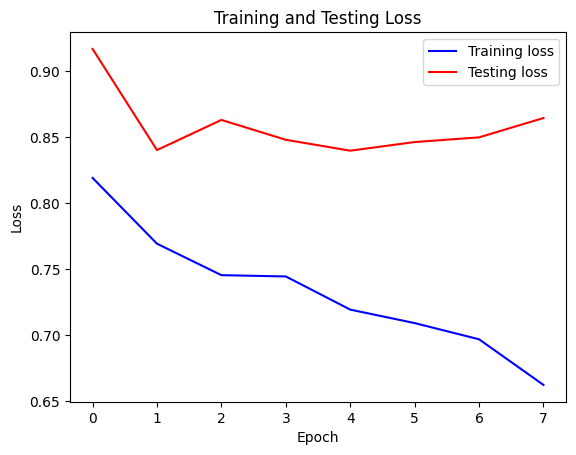

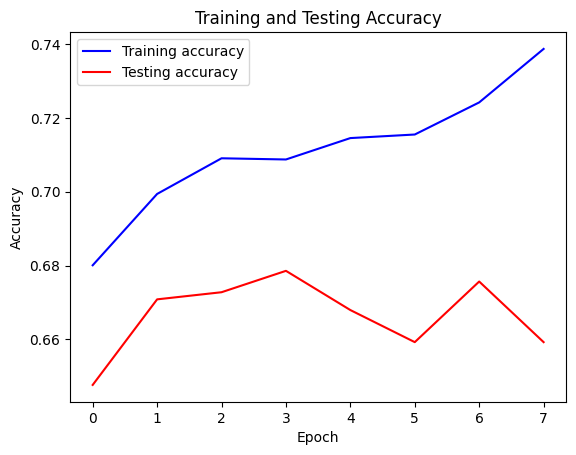

Other metrics:
--------------------------------------------------
Accuracy: 0.6593
Balanced Accuracy: 0.4102
Cohen’s kappa: 0.2300
F1 Score: 0.6007
Precision: 0.5760
Recall: 0.6593
Roc_auc_score: 0.6354
ROC AUC


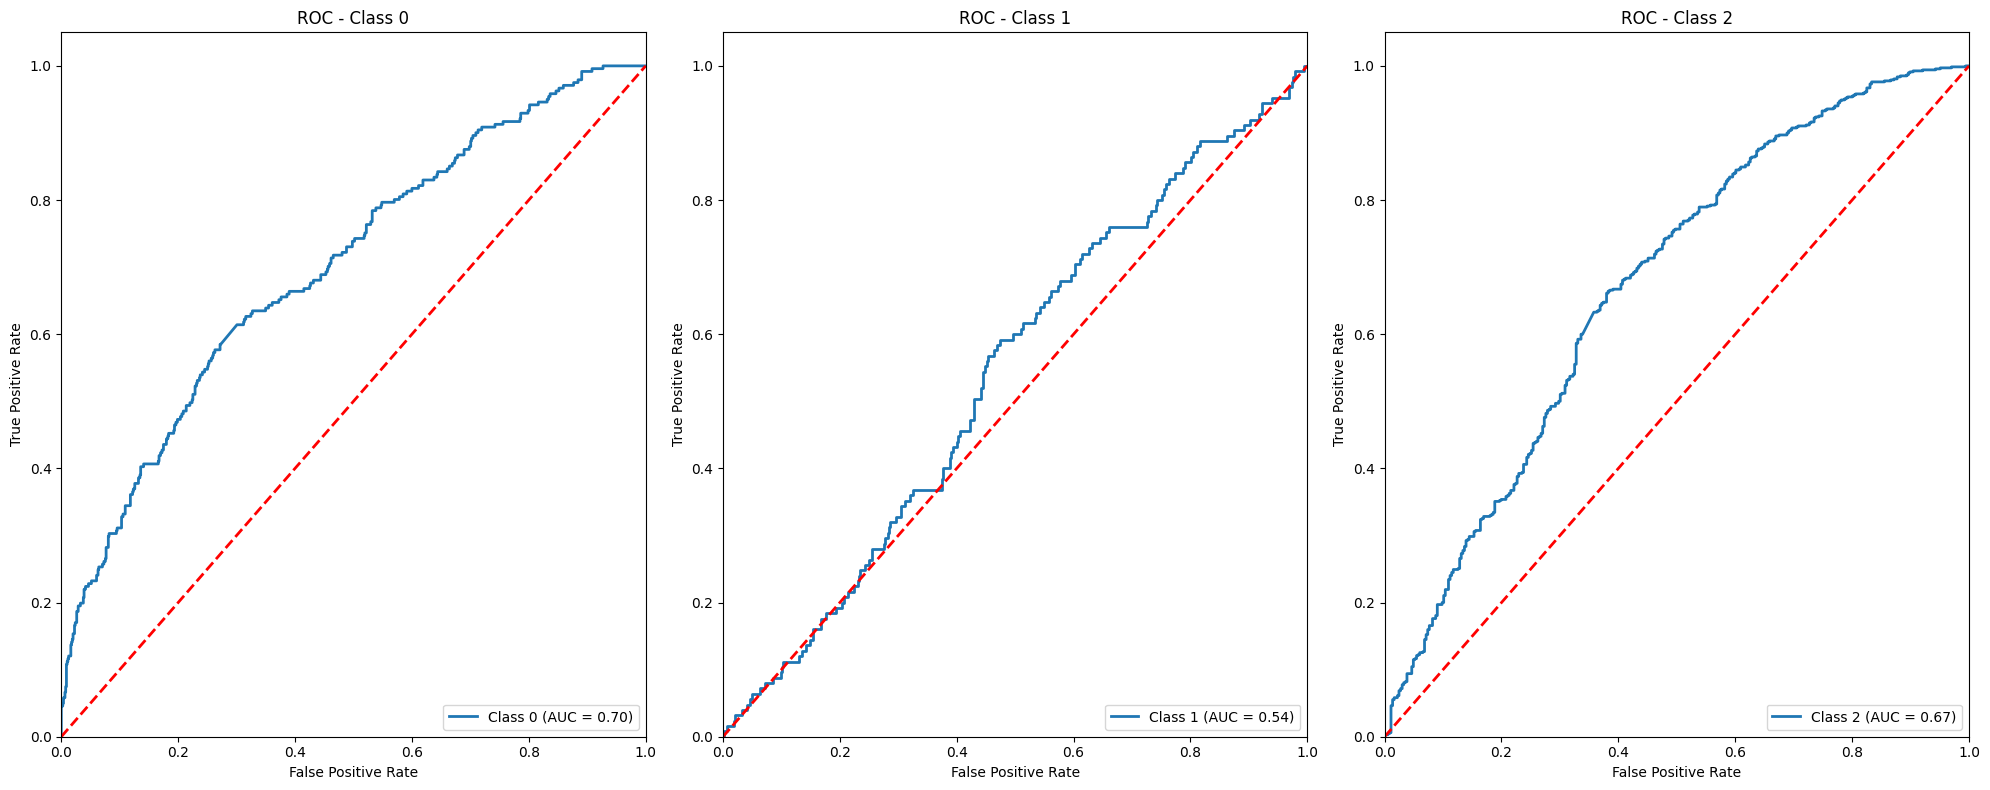

Confusion Matrix:



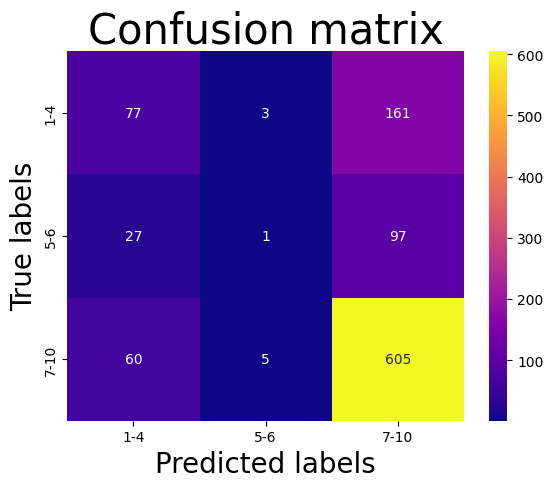

--------------------------------------------------
Training GRU model to predict rating :
Epoch: 1/5 | Train Loss: 0.8038 | Train Acc: 0.6910 | Test Loss: 0.8712 | Test Acc: 0.6631
Epoch: 2/5 | Train Loss: 0.7463 | Train Acc: 0.7168 | Test Loss: 0.8048 | Test Acc: 0.6776
Epoch: 3/5 | Train Loss: 0.7141 | Train Acc: 0.7271 | Test Loss: 0.8016 | Test Acc: 0.6795
Epoch: 4/5 | Train Loss: 0.6715 | Train Acc: 0.7403 | Test Loss: 0.8231 | Test Acc: 0.6902
Epoch: 5/5 | Train Loss: 0.6041 | Train Acc: 0.7644 | Test Loss: 0.8405 | Test Acc: 0.6583
Loss and accuracy:


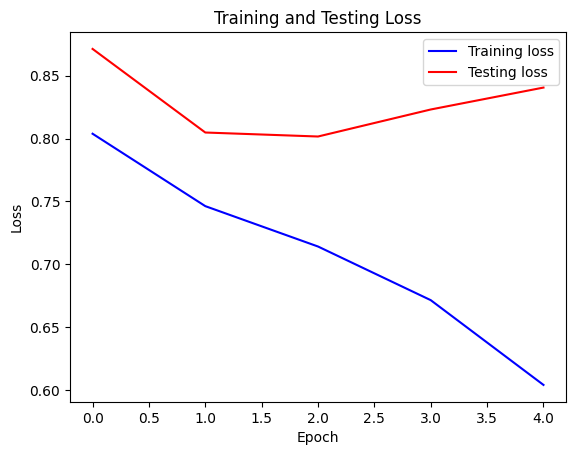

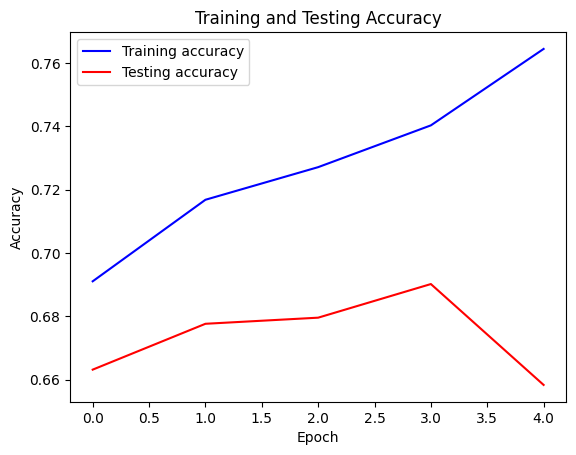

Other metrics:
--------------------------------------------------
Accuracy: 0.6583
Balanced Accuracy: 0.4526
Cohen’s kappa: 0.3340
F1 Score: 0.6275
Precision: 0.6022
Recall: 0.6583
Roc_auc_score: 0.669
ROC AUC


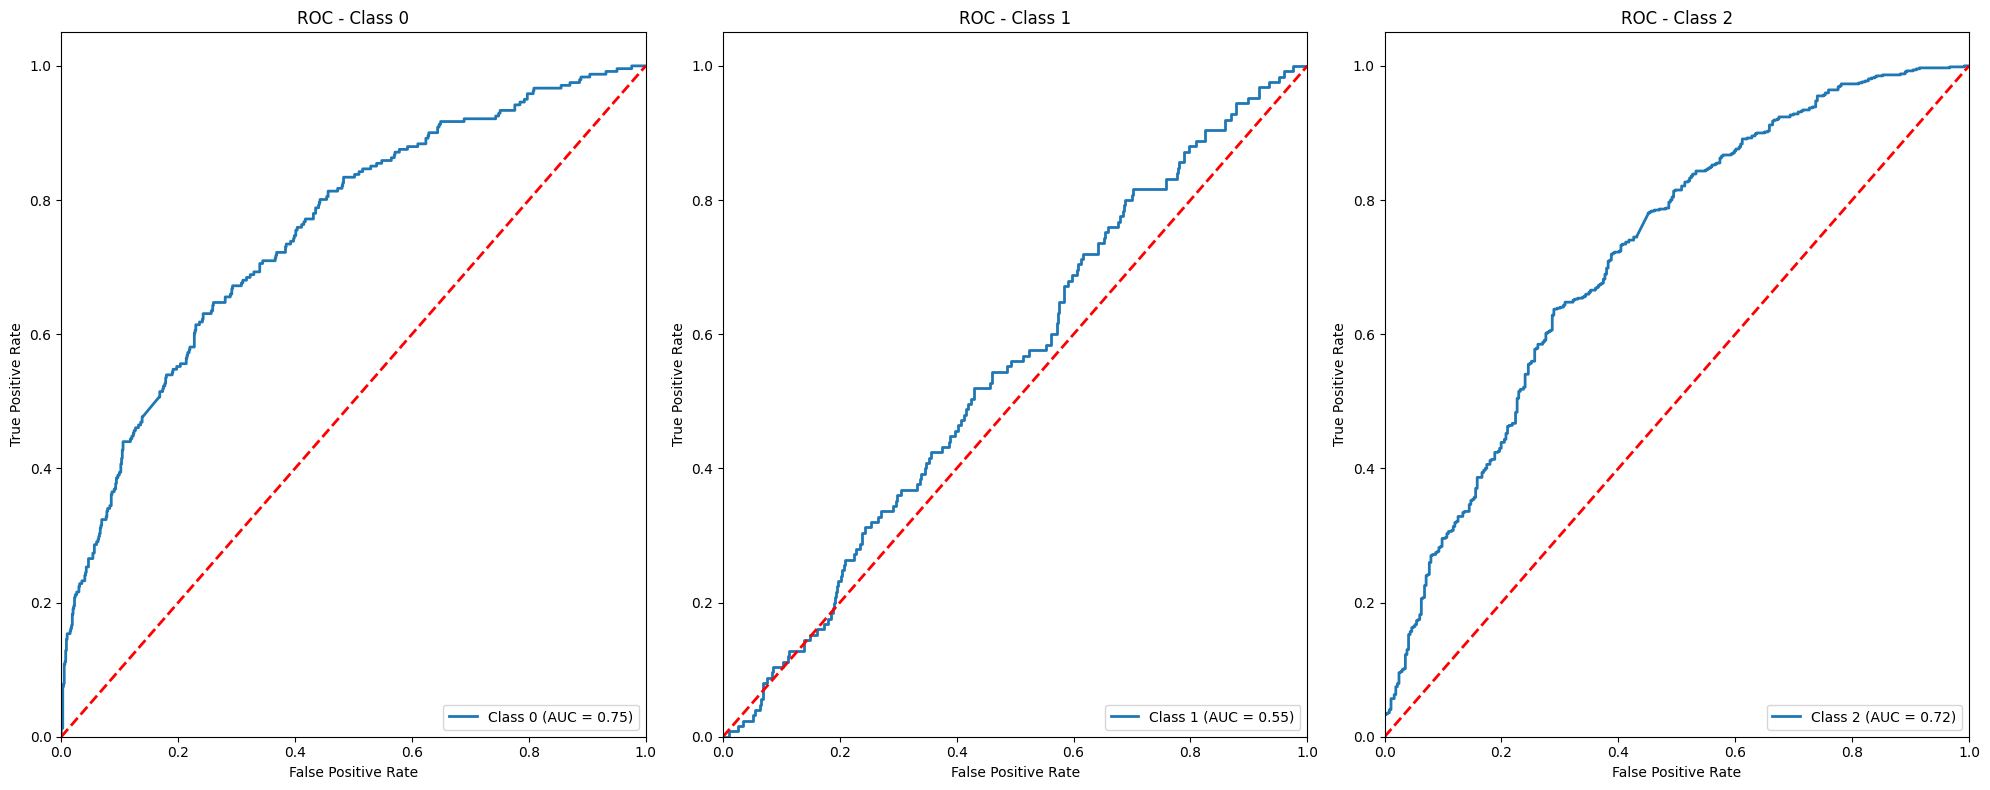

Confusion Matrix:



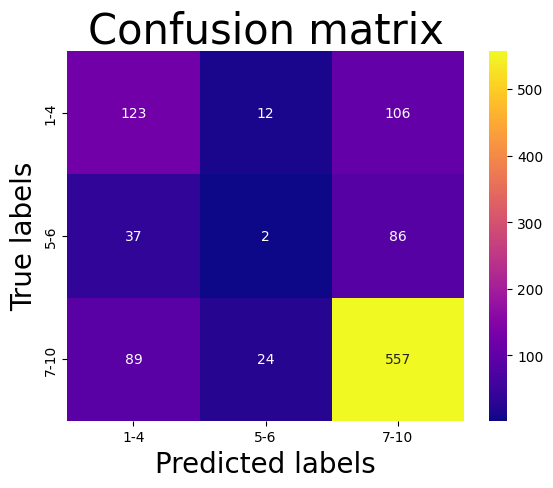

--------------------------------------------------
Training LSTM model to predict rating :
Epoch: 1/5 | Train Loss: 0.8127 | Train Acc: 0.6859 | Test Loss: 0.8474 | Test Acc: 0.6757
Epoch: 2/5 | Train Loss: 0.7544 | Train Acc: 0.7107 | Test Loss: 0.8134 | Test Acc: 0.6844
Epoch: 3/5 | Train Loss: 0.7213 | Train Acc: 0.7226 | Test Loss: 0.8032 | Test Acc: 0.6747
Epoch: 4/5 | Train Loss: 0.6871 | Train Acc: 0.7364 | Test Loss: 0.8323 | Test Acc: 0.6892
Epoch: 5/5 | Train Loss: 0.6449 | Train Acc: 0.7531 | Test Loss: 0.8234 | Test Acc: 0.6795
Loss and accuracy:


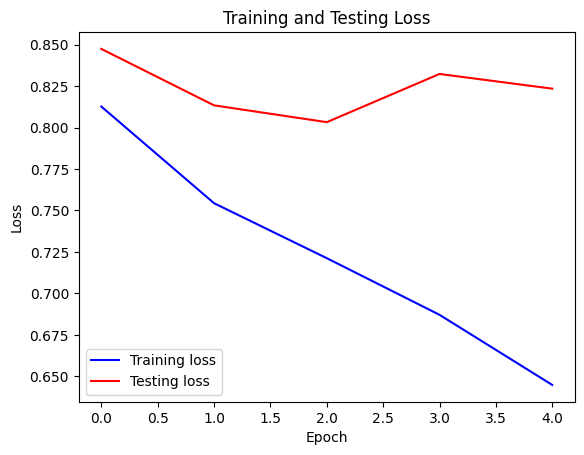

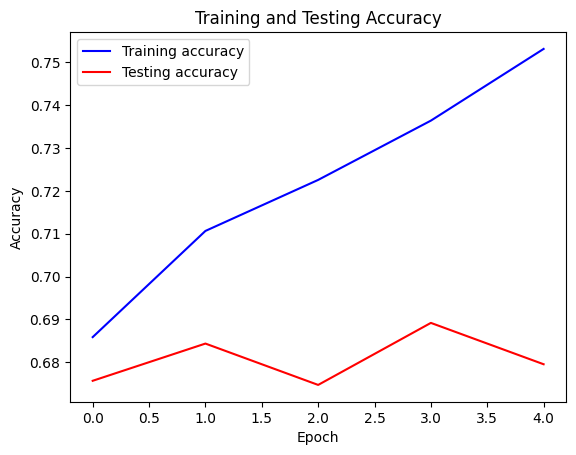

Other metrics:
--------------------------------------------------
Accuracy: 0.6795
Balanced Accuracy: 0.4344
Cohen’s kappa: 0.3020
F1 Score: 0.6239
Precision: 0.5854
Recall: 0.6795
Roc_auc_score: 0.6649
ROC AUC


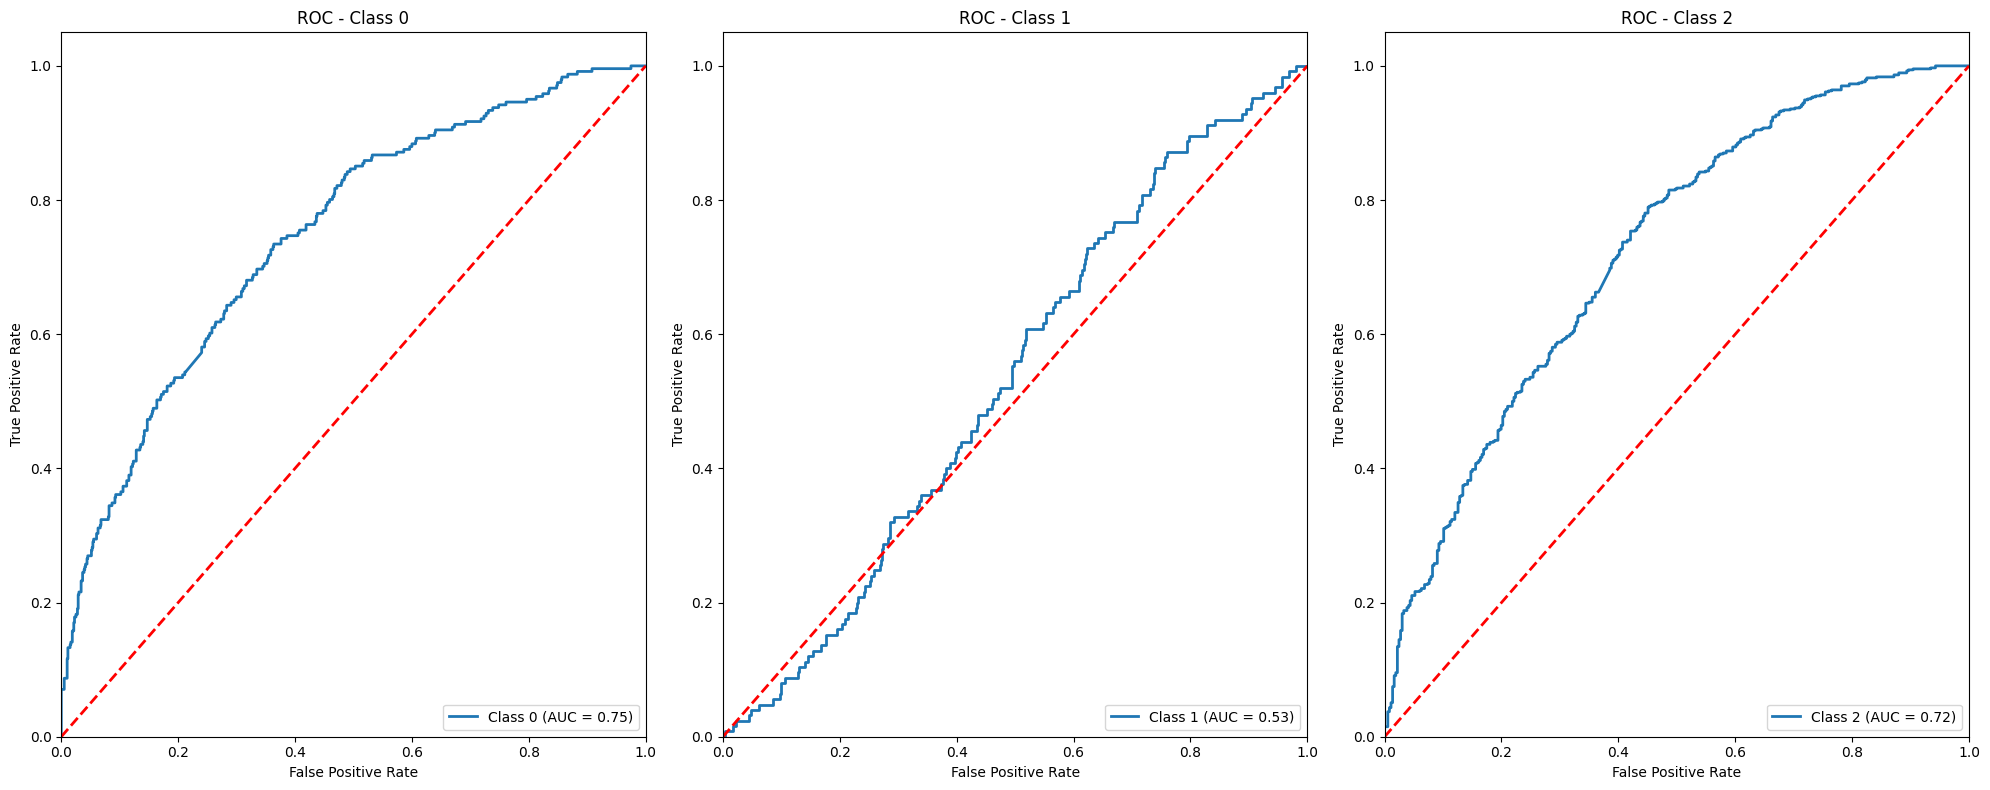

Confusion Matrix:



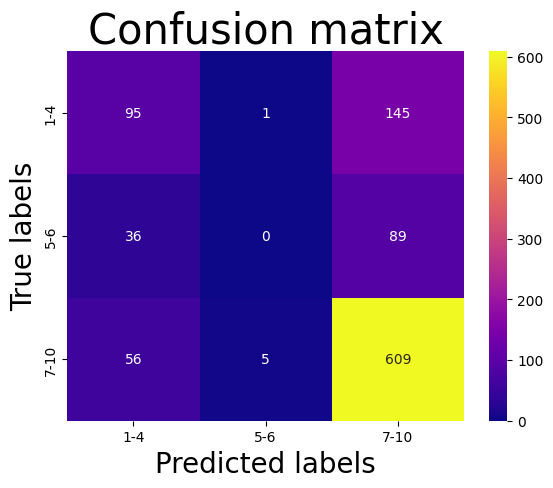

--------------------------------------------------


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model to predict rating :
Epoch: 1/3 | Train Loss: 0.8702 | Train Acc: 0.6801 | Test Loss: 0.9395 | Test Acc: 0.6467
Epoch: 2/3 | Train Loss: 0.8786 | Train Acc: 0.6691 | Test Loss: 1.0416 | Test Acc: 0.6429
Epoch: 3/3 | Train Loss: 0.8805 | Train Acc: 0.6720 | Test Loss: 0.9201 | Test Acc: 0.6467
Loss and accuracy:


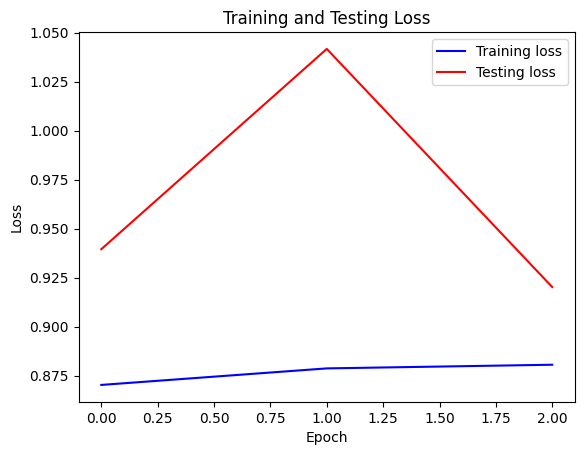

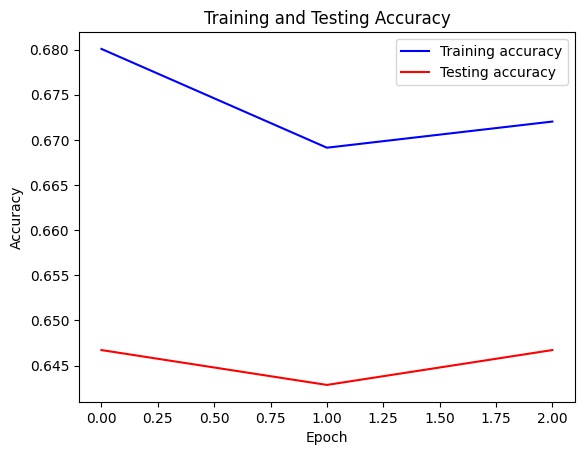

Other metrics:
--------------------------------------------------
Accuracy: 0.6467
Balanced Accuracy: 0.3333
Cohen’s kappa: 0.0000
F1 Score: 0.5080
Precision: 0.4182
Recall: 0.6467
Roc_auc_score: 0.4914
ROC AUC


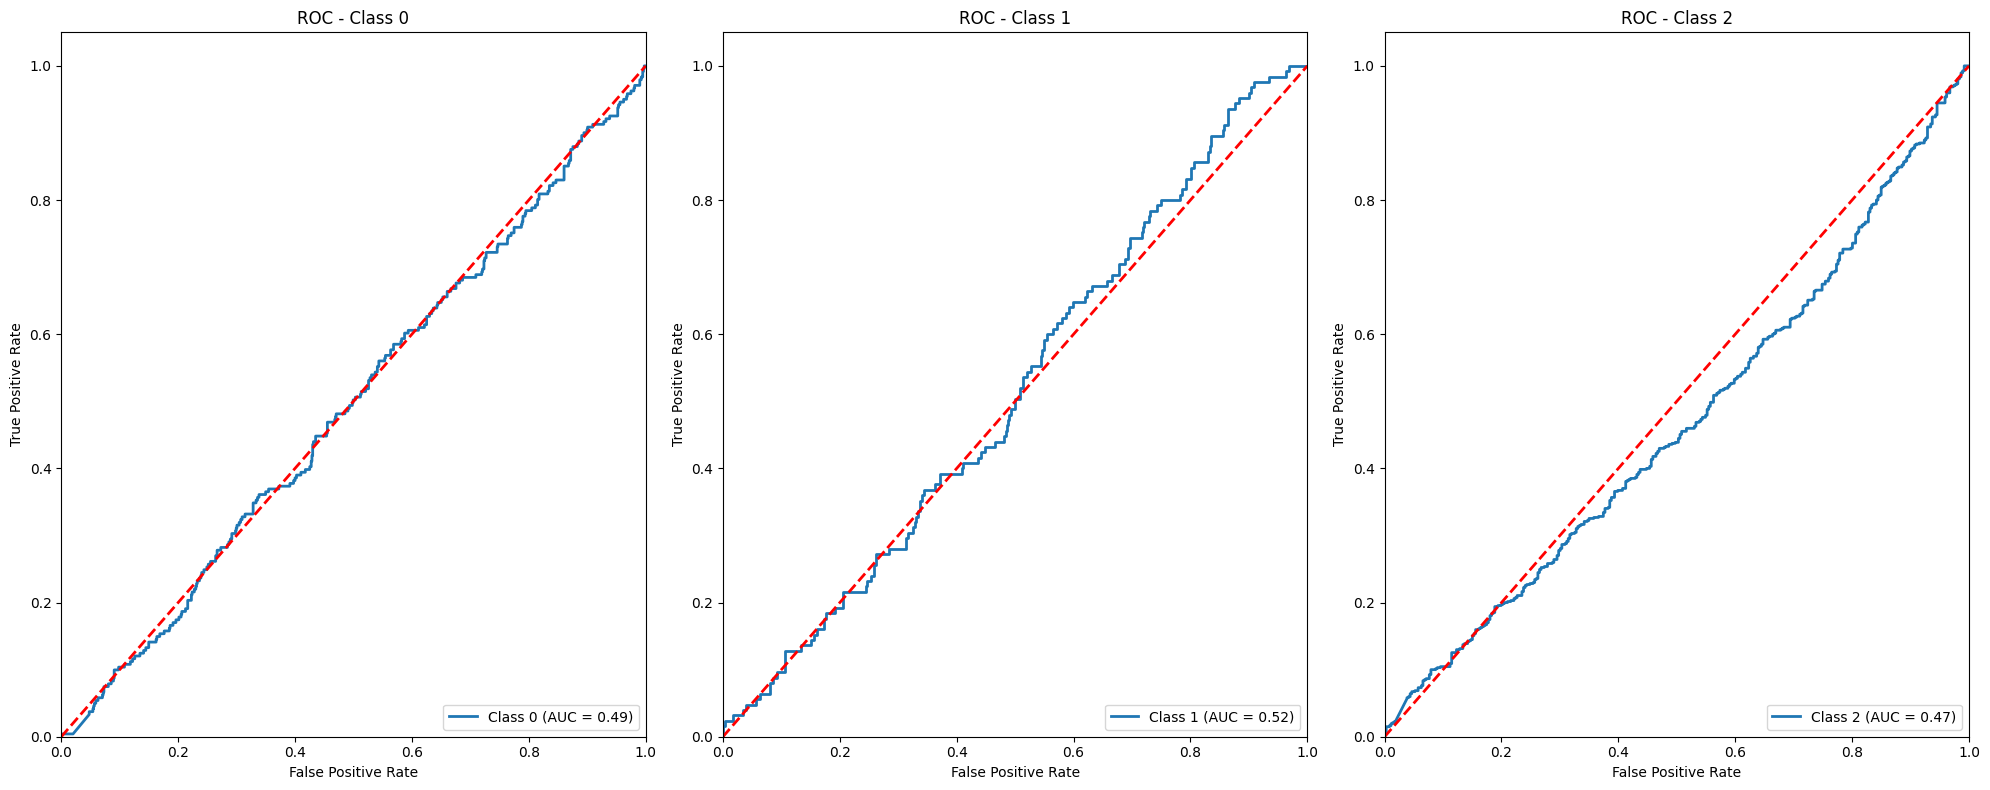

Confusion Matrix:



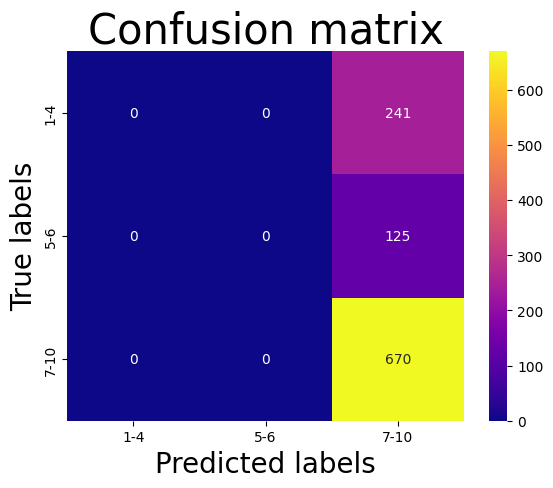

--------------------------------------------------


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training GPT model to predict rating :
Epoch: 1/3 | Train Loss: 0.9169 | Train Acc: 0.6685 | Test Loss: 0.8583 | Test Acc: 0.6390
Epoch: 2/3 | Train Loss: 0.7577 | Train Acc: 0.7103 | Test Loss: 0.8032 | Test Acc: 0.6882
Epoch: 3/3 | Train Loss: 0.7190 | Train Acc: 0.7303 | Test Loss: 0.7991 | Test Acc: 0.6844
Loss and accuracy:


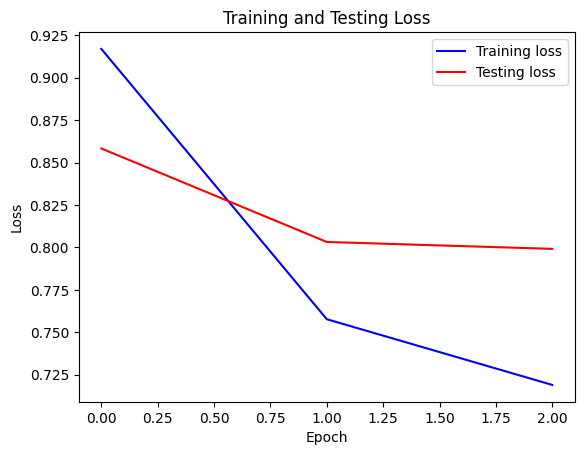

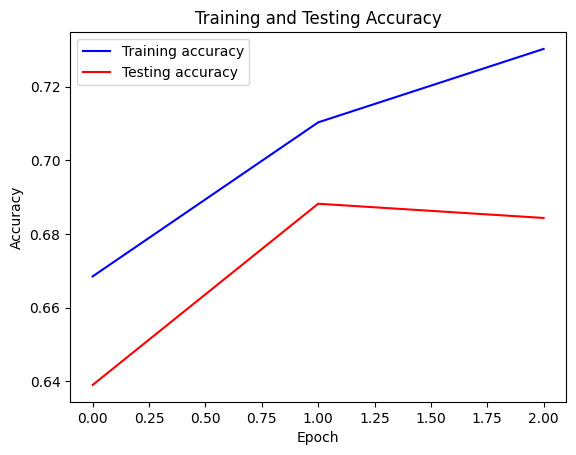

Other metrics:
--------------------------------------------------
Accuracy: 0.6844
Balanced Accuracy: 0.3935
Cohen’s kappa: 0.1963
F1 Score: 0.5924
Precision: 0.6181
Recall: 0.6844
Roc_auc_score: 0.731
ROC AUC


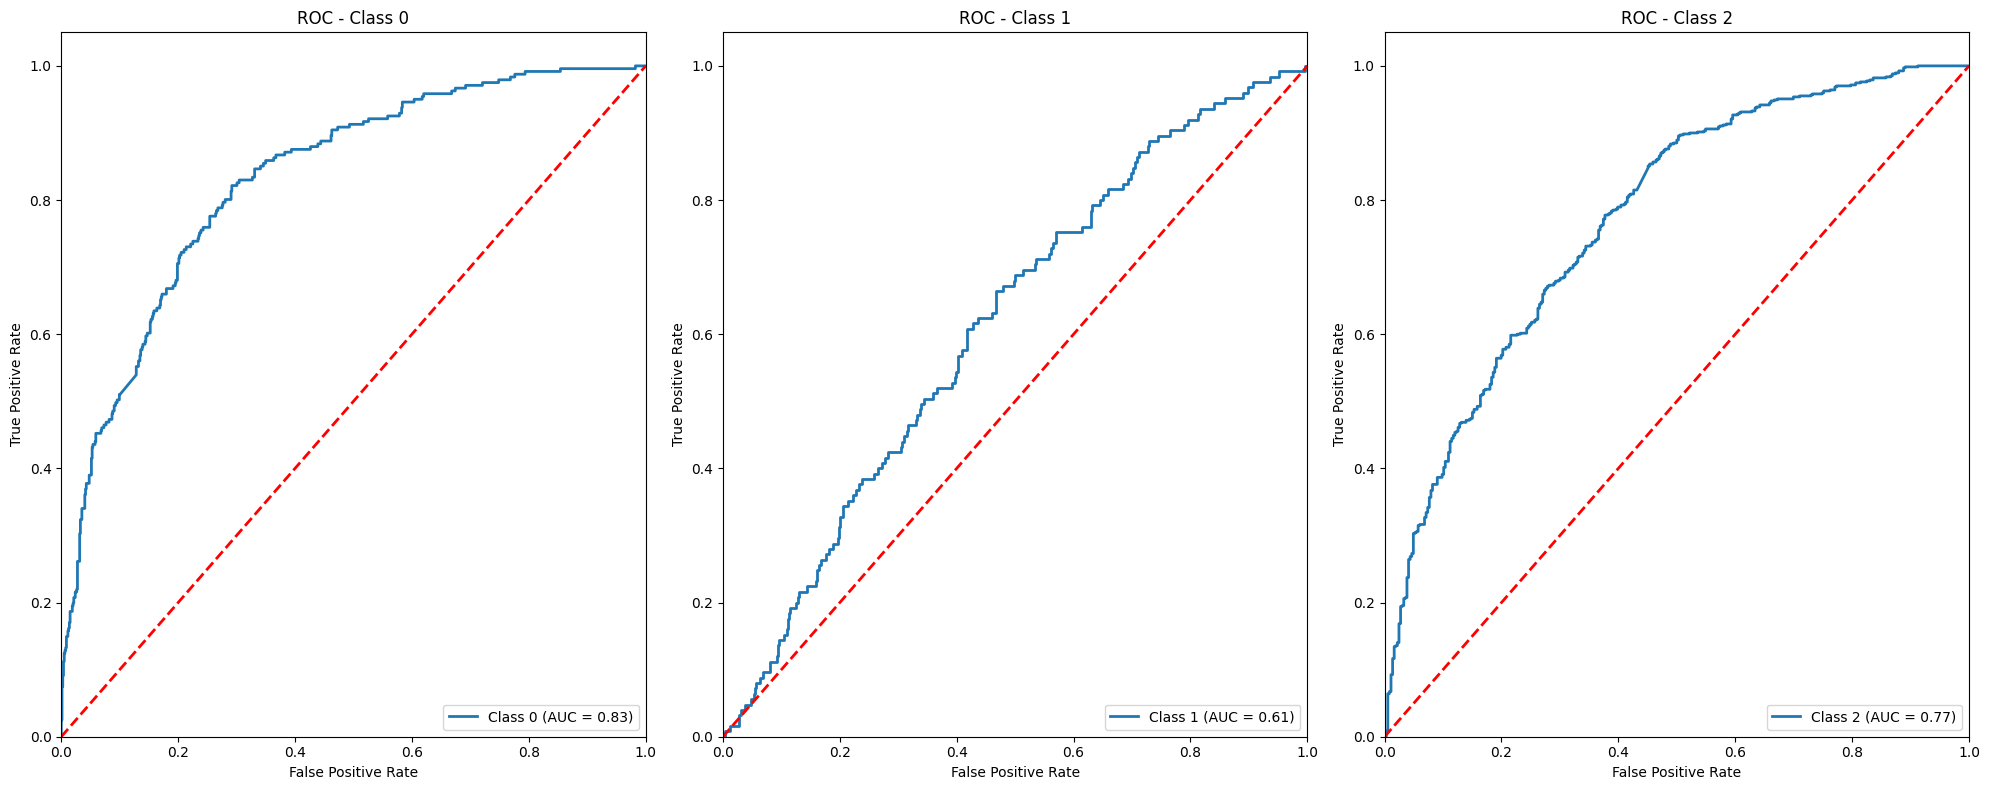

Confusion Matrix:



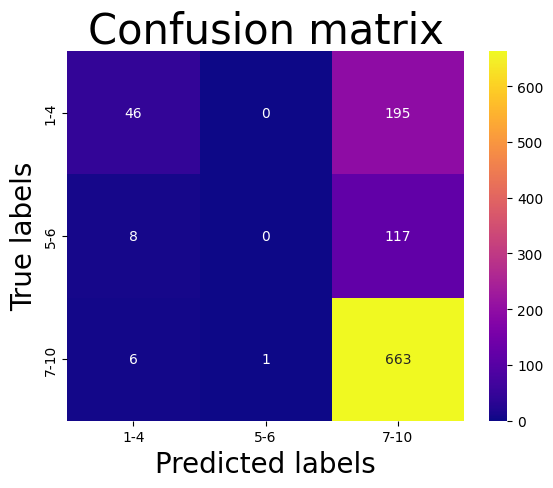

--------------------------------------------------
Training RNN model to predict effectiveness :
Epoch: 1/8 | Train Loss: 0.7260 | Train Acc: 0.7322 | Test Loss: 0.6914 | Test Acc: 0.7172
Epoch: 2/8 | Train Loss: 0.6615 | Train Acc: 0.7454 | Test Loss: 0.6751 | Test Acc: 0.7230
Epoch: 3/8 | Train Loss: 0.6330 | Train Acc: 0.7480 | Test Loss: 0.6891 | Test Acc: 0.7162
Epoch: 4/8 | Train Loss: 0.6057 | Train Acc: 0.7621 | Test Loss: 0.6916 | Test Acc: 0.7075
Epoch: 5/8 | Train Loss: 0.5972 | Train Acc: 0.7612 | Test Loss: 0.7139 | Test Acc: 0.7143
Epoch: 6/8 | Train Loss: 0.5763 | Train Acc: 0.7657 | Test Loss: 0.7057 | Test Acc: 0.7384
Epoch: 7/8 | Train Loss: 0.5501 | Train Acc: 0.7779 | Test Loss: 0.7149 | Test Acc: 0.7307
Epoch: 8/8 | Train Loss: 0.5373 | Train Acc: 0.7856 | Test Loss: 0.7151 | Test Acc: 0.7095
Loss and accuracy:


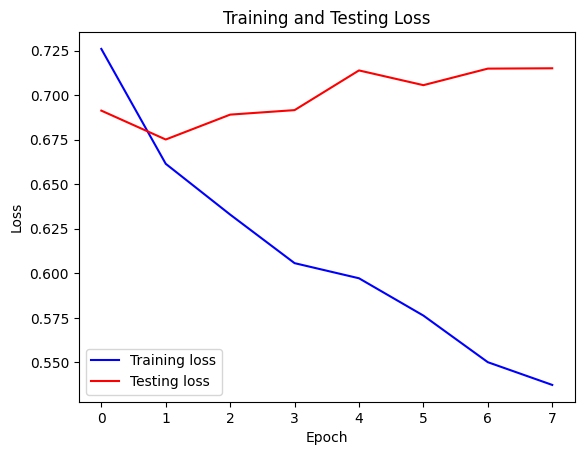

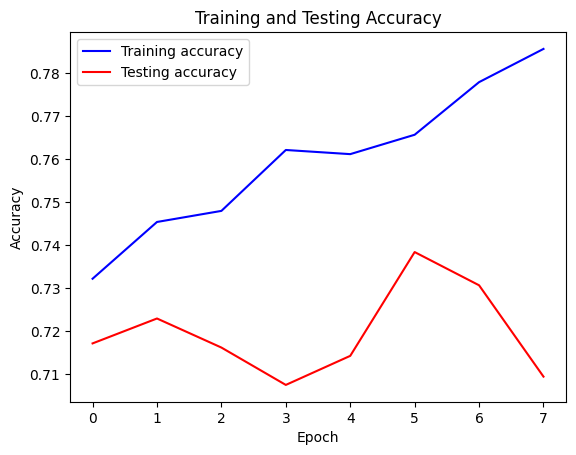

Other metrics:
--------------------------------------------------
Accuracy: 0.7095
Balanced Accuracy: 0.4571
Cohen’s kappa: 0.2631
F1 Score: 0.6628
Precision: 0.6697
Recall: 0.7095
Roc_auc_score: 0.7252
ROC AUC


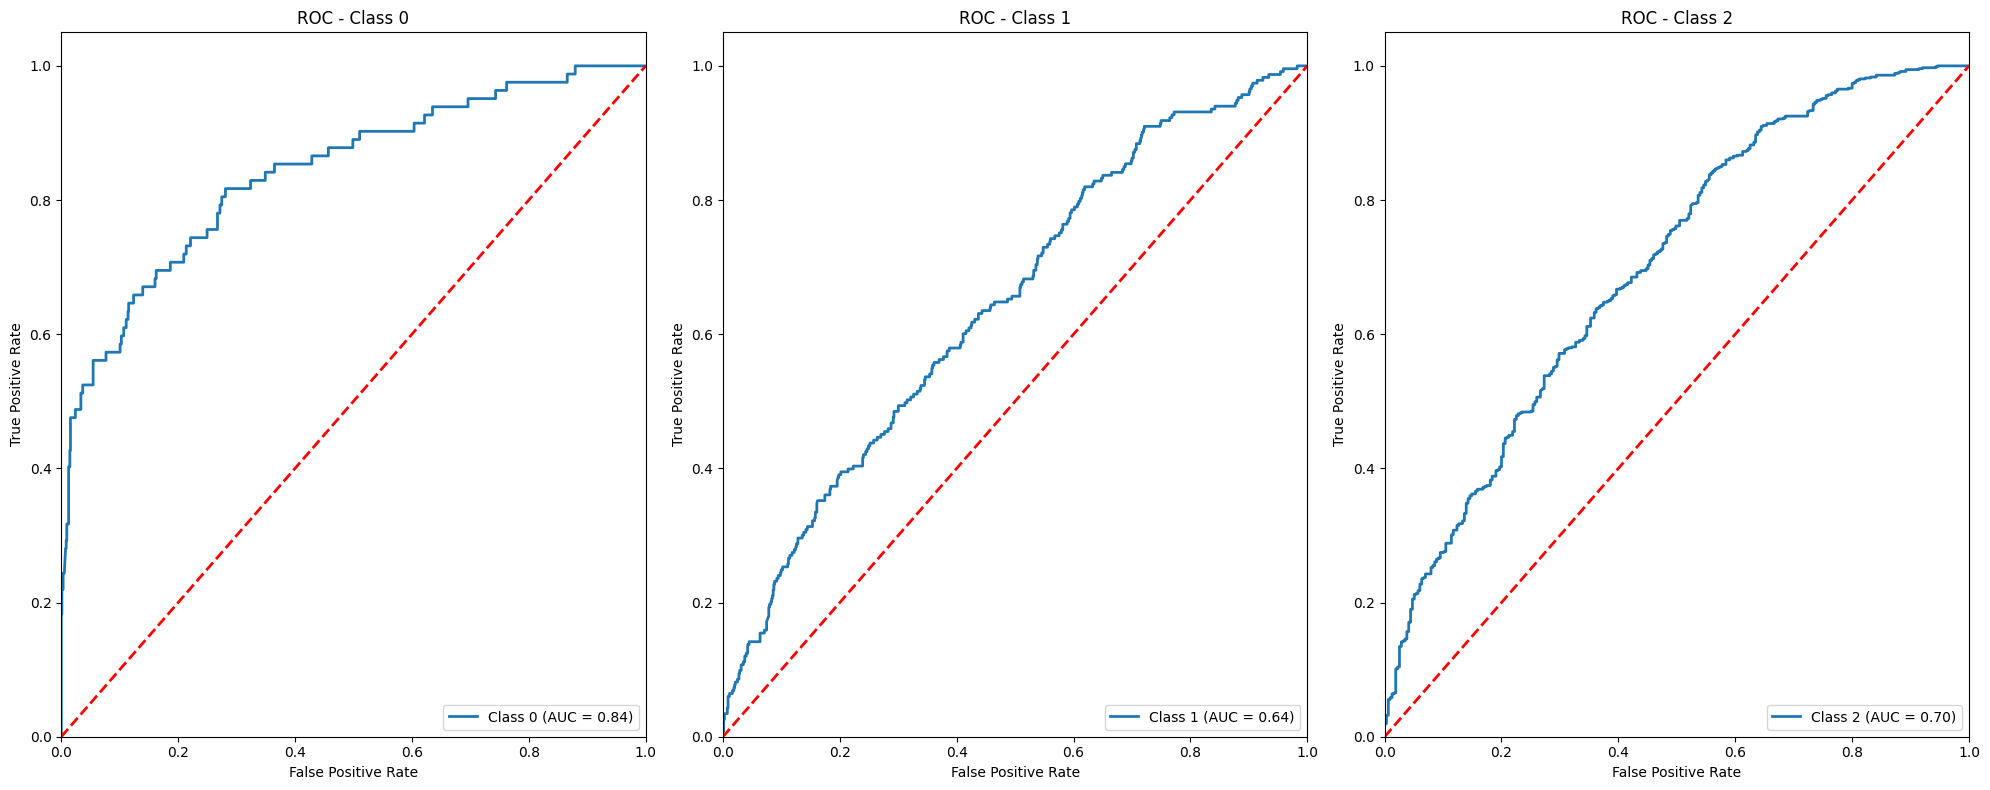

Confusion Matrix:



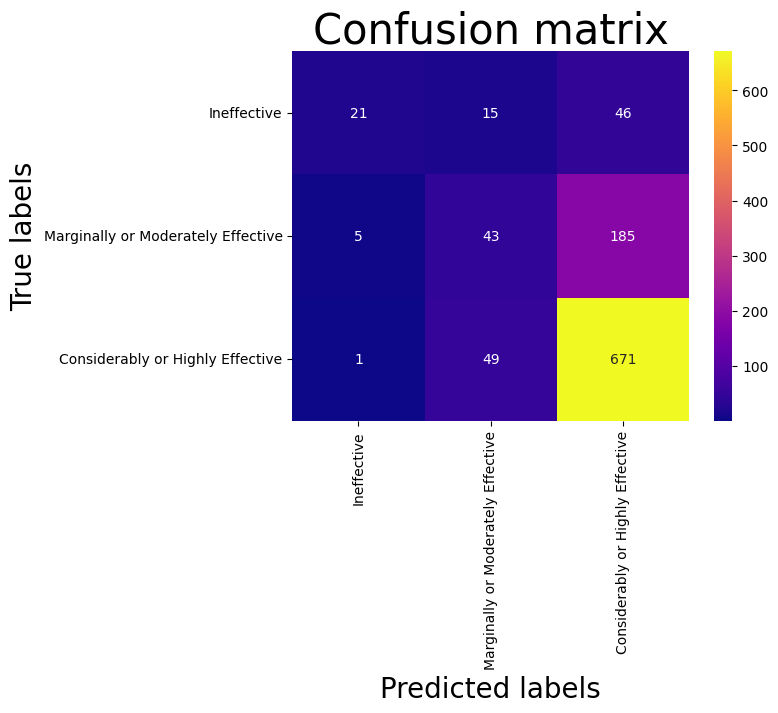

--------------------------------------------------
Training GRU model to predict effectiveness :
Epoch: 1/5 | Train Loss: 0.6896 | Train Acc: 0.7399 | Test Loss: 0.7562 | Test Acc: 0.7239
Epoch: 2/5 | Train Loss: 0.6099 | Train Acc: 0.7634 | Test Loss: 0.6405 | Test Acc: 0.7452
Epoch: 3/5 | Train Loss: 0.5710 | Train Acc: 0.7734 | Test Loss: 0.6788 | Test Acc: 0.7432
Epoch: 4/5 | Train Loss: 0.5356 | Train Acc: 0.7940 | Test Loss: 0.6467 | Test Acc: 0.7490
Epoch: 5/5 | Train Loss: 0.4821 | Train Acc: 0.8075 | Test Loss: 0.6898 | Test Acc: 0.7442
Loss and accuracy:


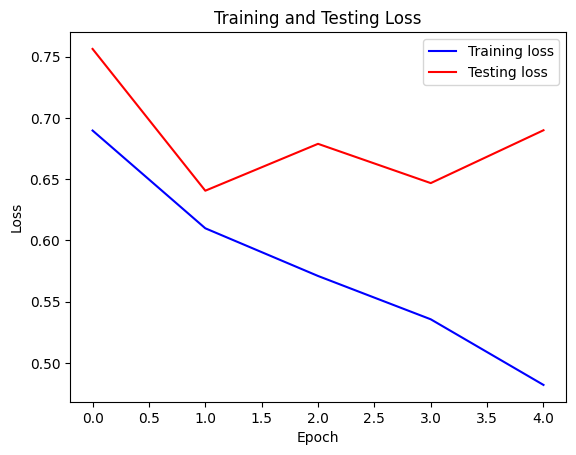

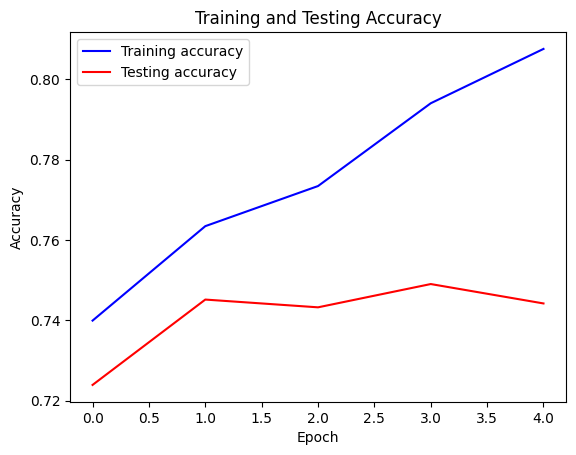

Other metrics:
--------------------------------------------------
Accuracy: 0.7442
Balanced Accuracy: 0.5284
Cohen’s kappa: 0.3736
F1 Score: 0.6790
Precision: 0.7236
Recall: 0.7442
Roc_auc_score: 0.7797
ROC AUC


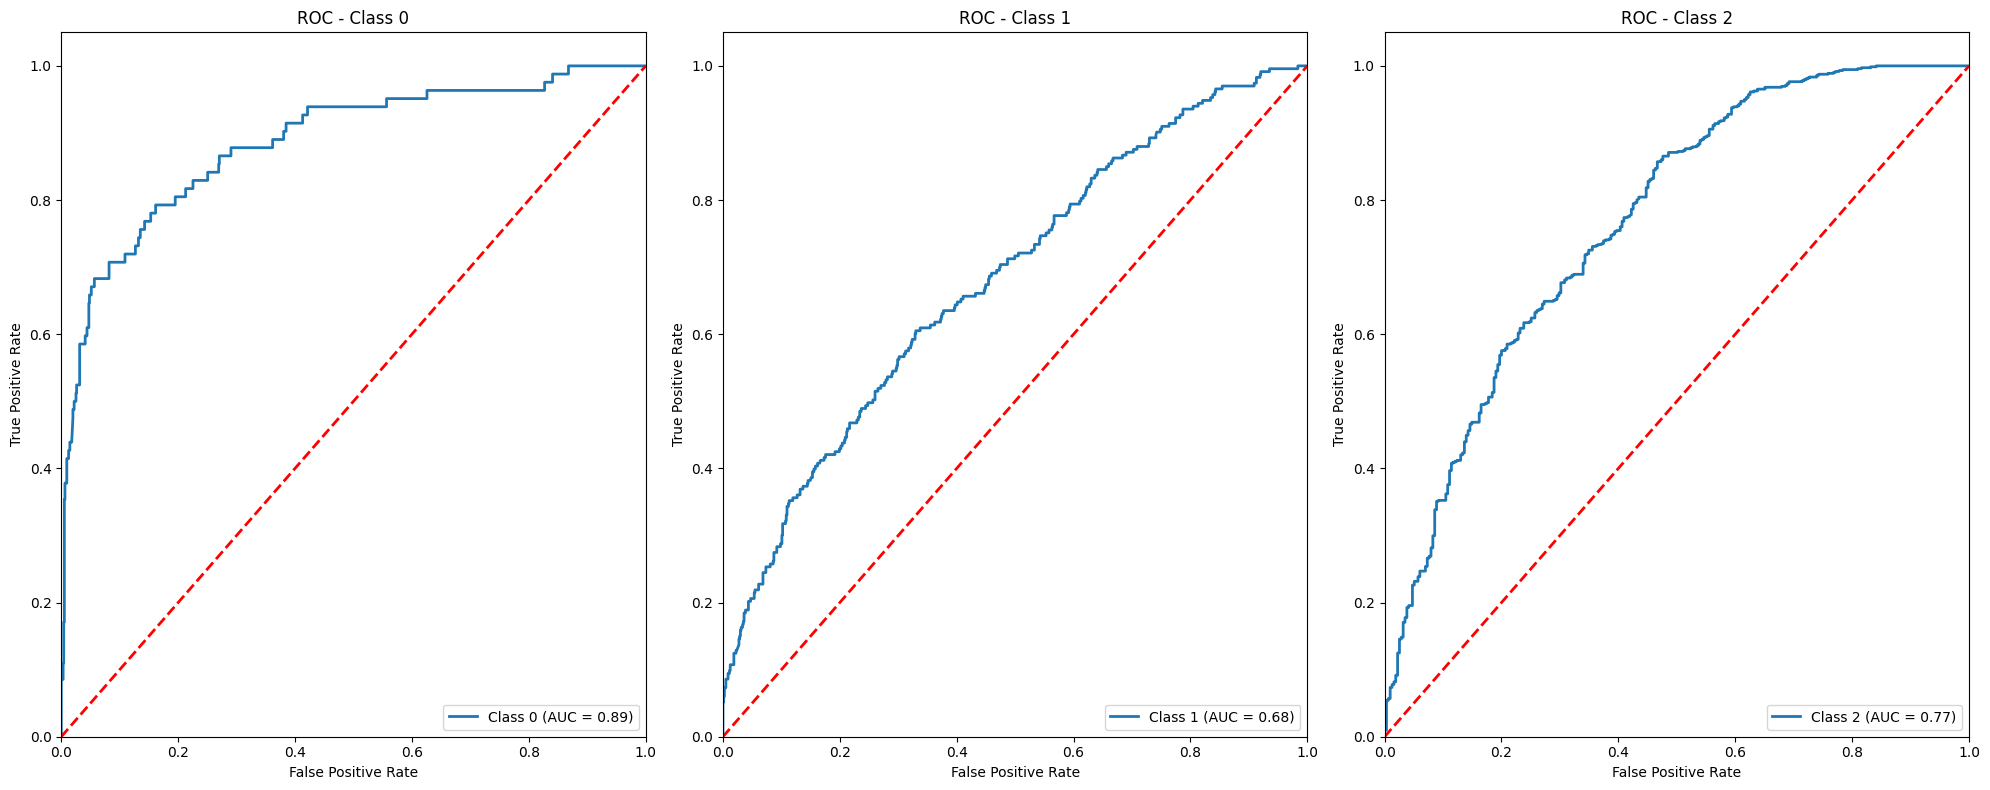

Confusion Matrix:



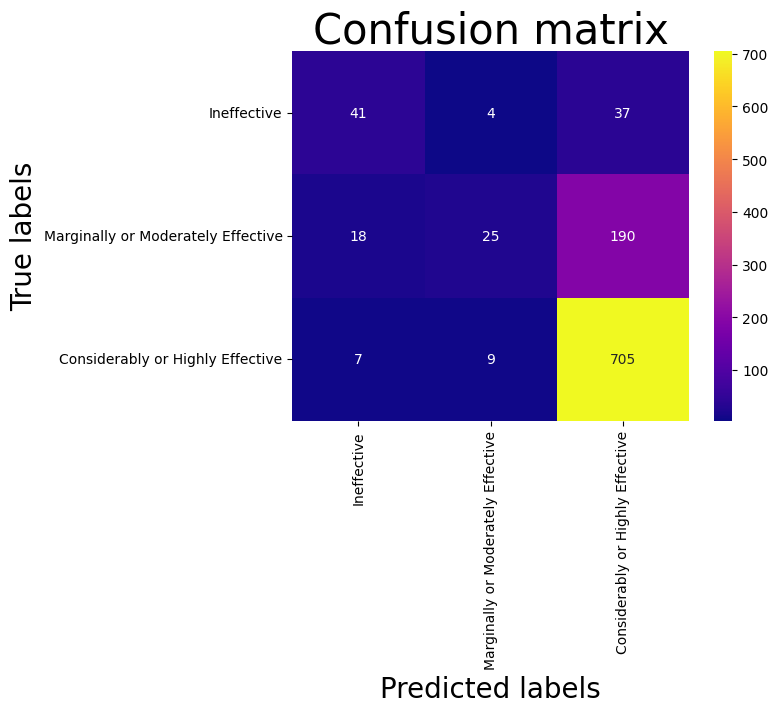

--------------------------------------------------
Training LSTM model to predict effectiveness :
Epoch: 1/5 | Train Loss: 0.7094 | Train Acc: 0.7335 | Test Loss: 0.6944 | Test Acc: 0.7220
Epoch: 2/5 | Train Loss: 0.6300 | Train Acc: 0.7535 | Test Loss: 0.6565 | Test Acc: 0.7336
Epoch: 3/5 | Train Loss: 0.5939 | Train Acc: 0.7609 | Test Loss: 0.7009 | Test Acc: 0.7326
Epoch: 4/5 | Train Loss: 0.5505 | Train Acc: 0.7805 | Test Loss: 0.6532 | Test Acc: 0.7423
Epoch: 5/5 | Train Loss: 0.5155 | Train Acc: 0.7963 | Test Loss: 0.6815 | Test Acc: 0.7268
Loss and accuracy:


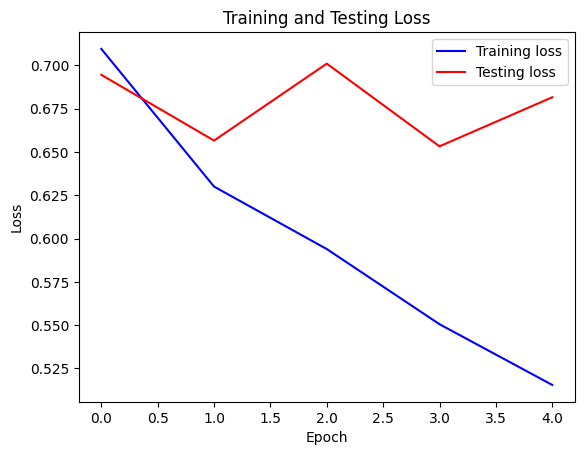

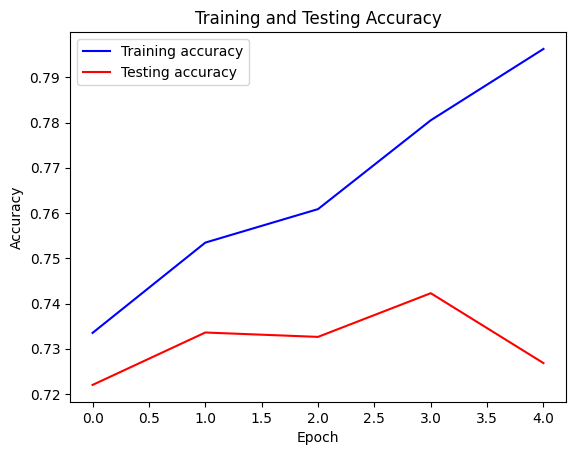

Other metrics:
--------------------------------------------------
Accuracy: 0.7268
Balanced Accuracy: 0.5689
Cohen’s kappa: 0.3904
F1 Score: 0.6873
Precision: 0.6889
Recall: 0.7268
Roc_auc_score: 0.7659
ROC AUC


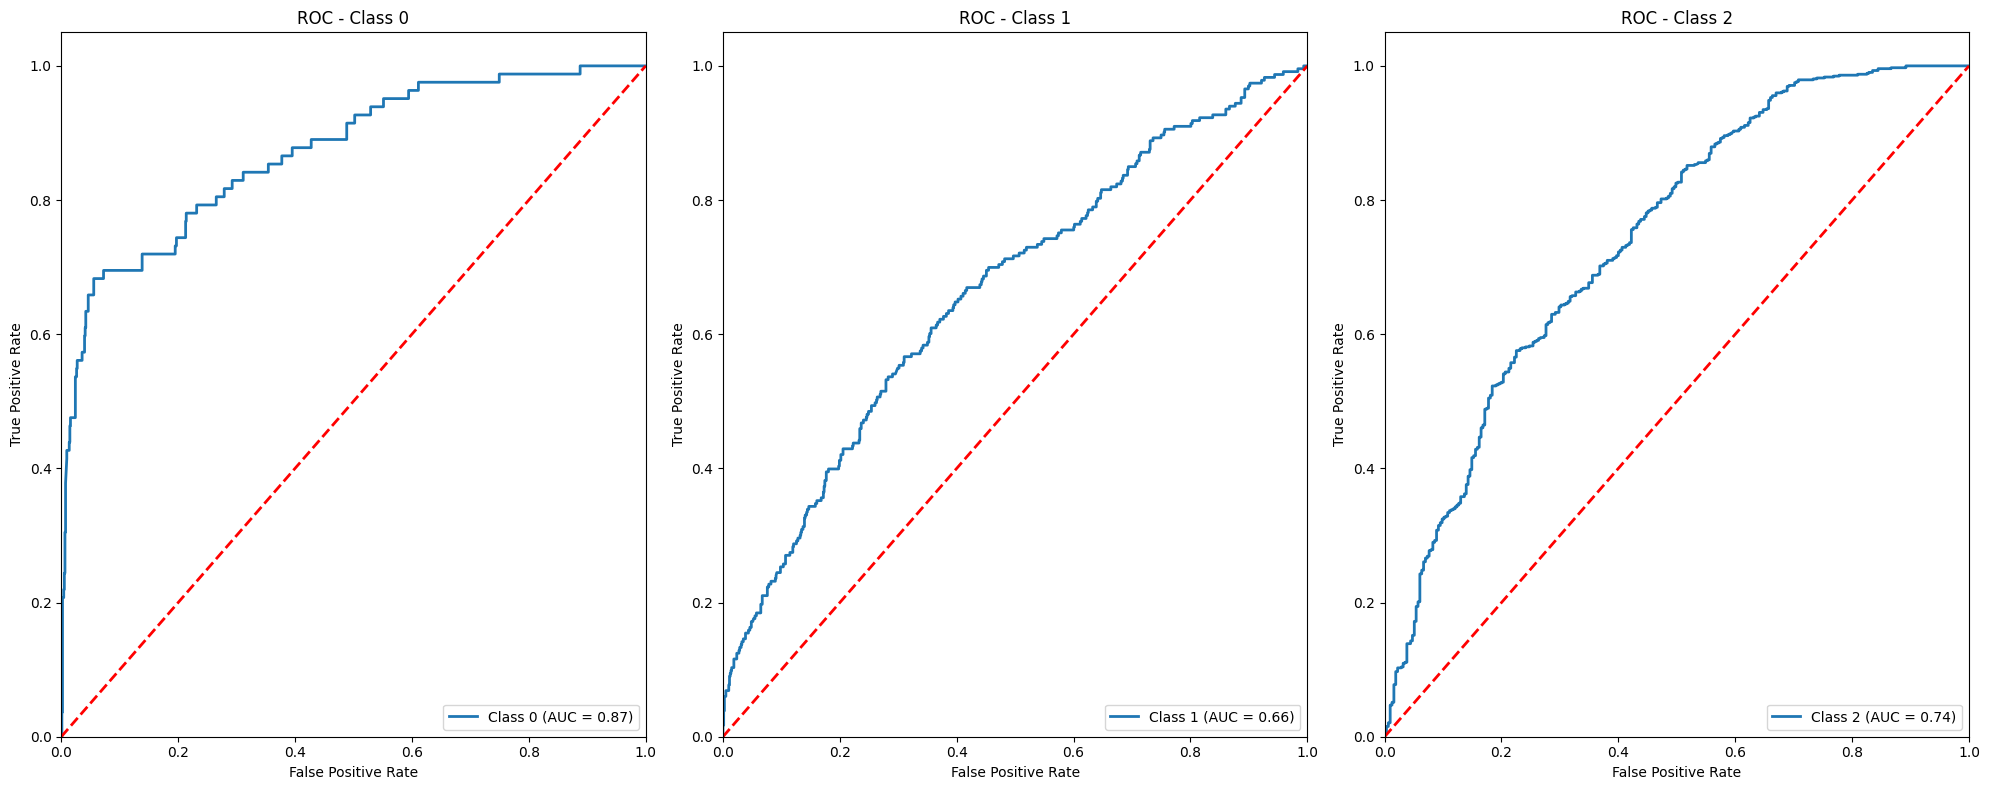

Confusion Matrix:



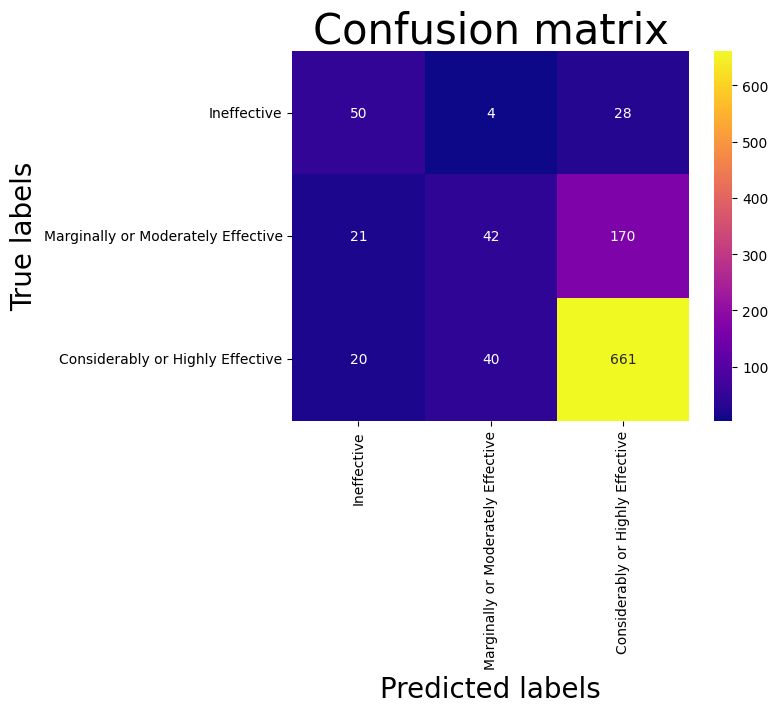

--------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model to predict effectiveness :
Epoch: 1/3 | Train Loss: 0.7904 | Train Acc: 0.7216 | Test Loss: 0.7860 | Test Acc: 0.6959
Epoch: 2/3 | Train Loss: 0.7862 | Train Acc: 0.7216 | Test Loss: 0.8470 | Test Acc: 0.6959
Epoch: 3/3 | Train Loss: 0.7666 | Train Acc: 0.7255 | Test Loss: 0.8367 | Test Acc: 0.6959
Loss and accuracy:


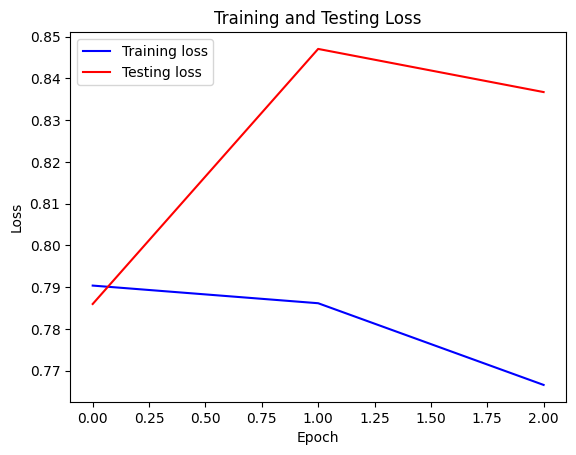

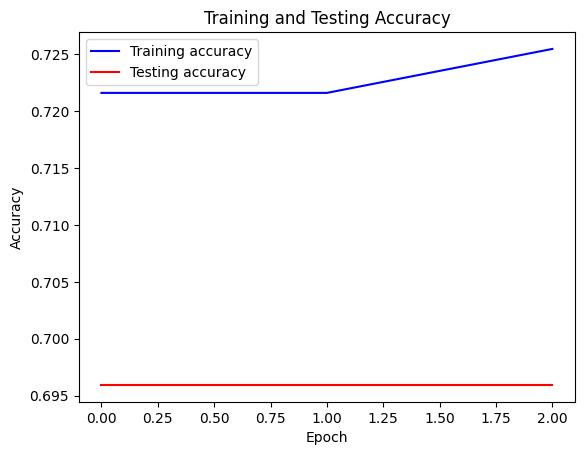

Other metrics:
--------------------------------------------------
Accuracy: 0.6959
Balanced Accuracy: 0.3333
Cohen’s kappa: 0.0000
F1 Score: 0.5712
Precision: 0.4843
Recall: 0.6959
Roc_auc_score: 0.5854
ROC AUC


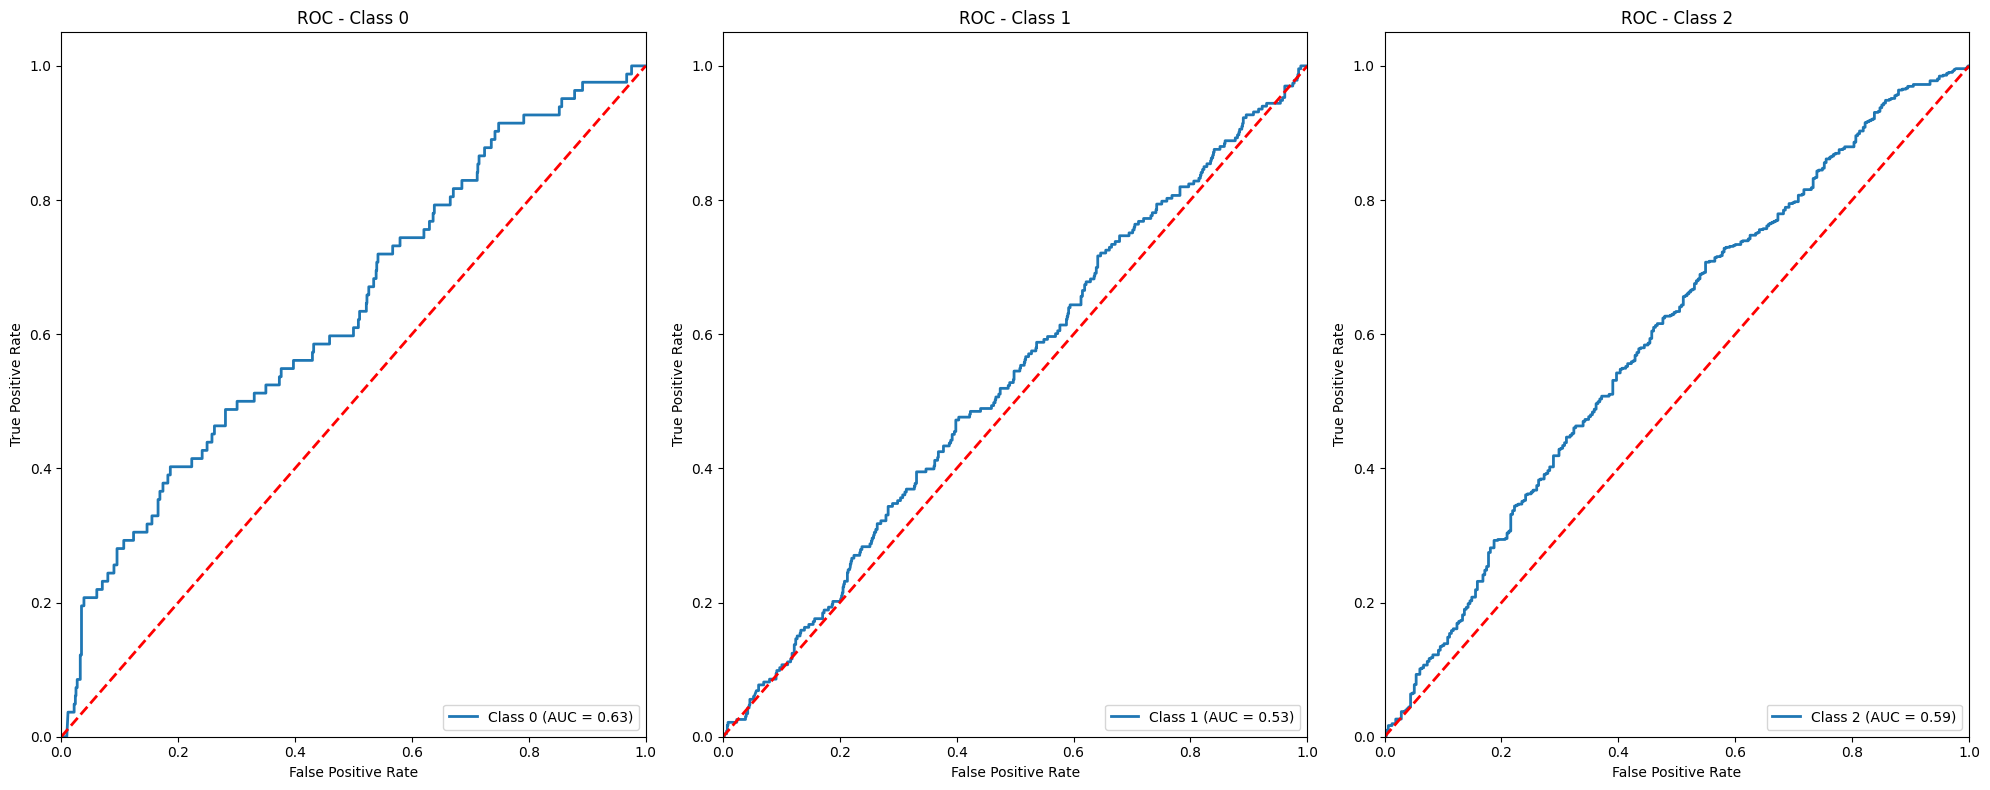

Confusion Matrix:



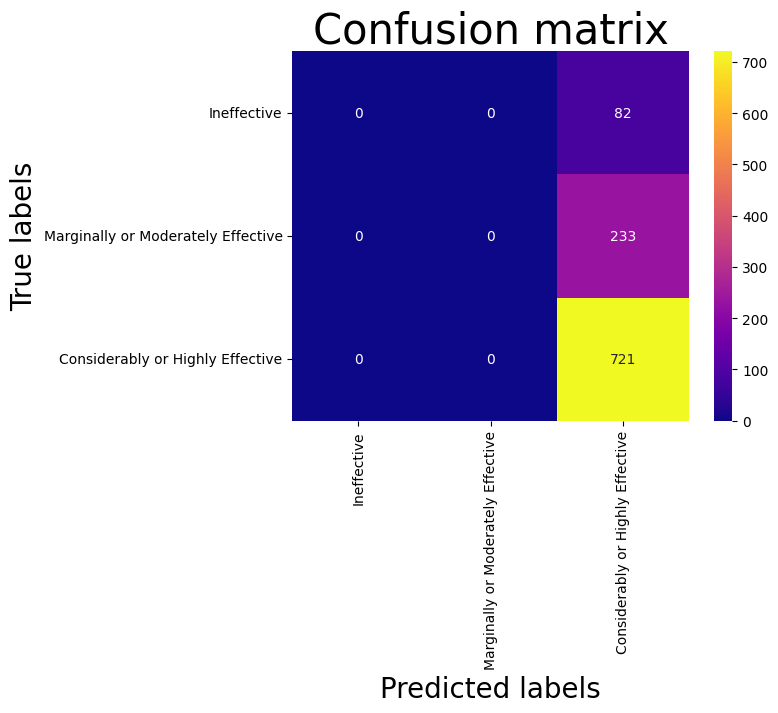

--------------------------------------------------


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training GPT model to predict effectiveness :
Epoch: 1/3 | Train Loss: 0.8080 | Train Acc: 0.6978 | Test Loss: 0.8163 | Test Acc: 0.7114
Epoch: 2/3 | Train Loss: 0.6813 | Train Acc: 0.7354 | Test Loss: 0.7598 | Test Acc: 0.6612
Epoch: 3/3 | Train Loss: 0.6465 | Train Acc: 0.7399 | Test Loss: 0.6584 | Test Acc: 0.7162
Loss and accuracy:


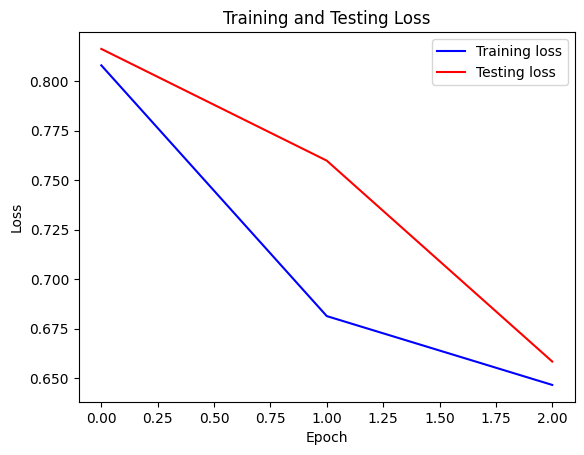

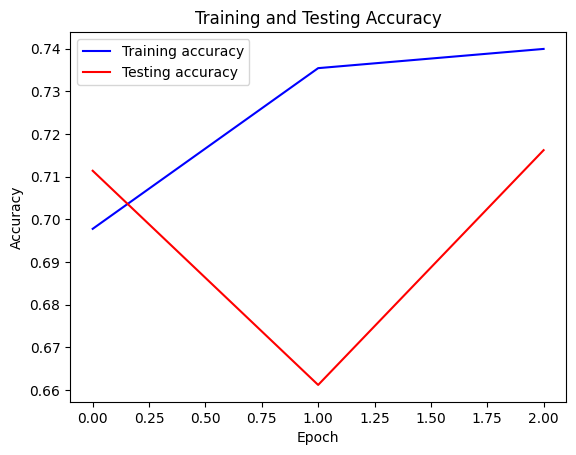

Other metrics:
--------------------------------------------------
Accuracy: 0.7162
Balanced Accuracy: 0.4950
Cohen’s kappa: 0.3191
F1 Score: 0.6783
Precision: 0.6765
Recall: 0.7162
Roc_auc_score: 0.7701
ROC AUC


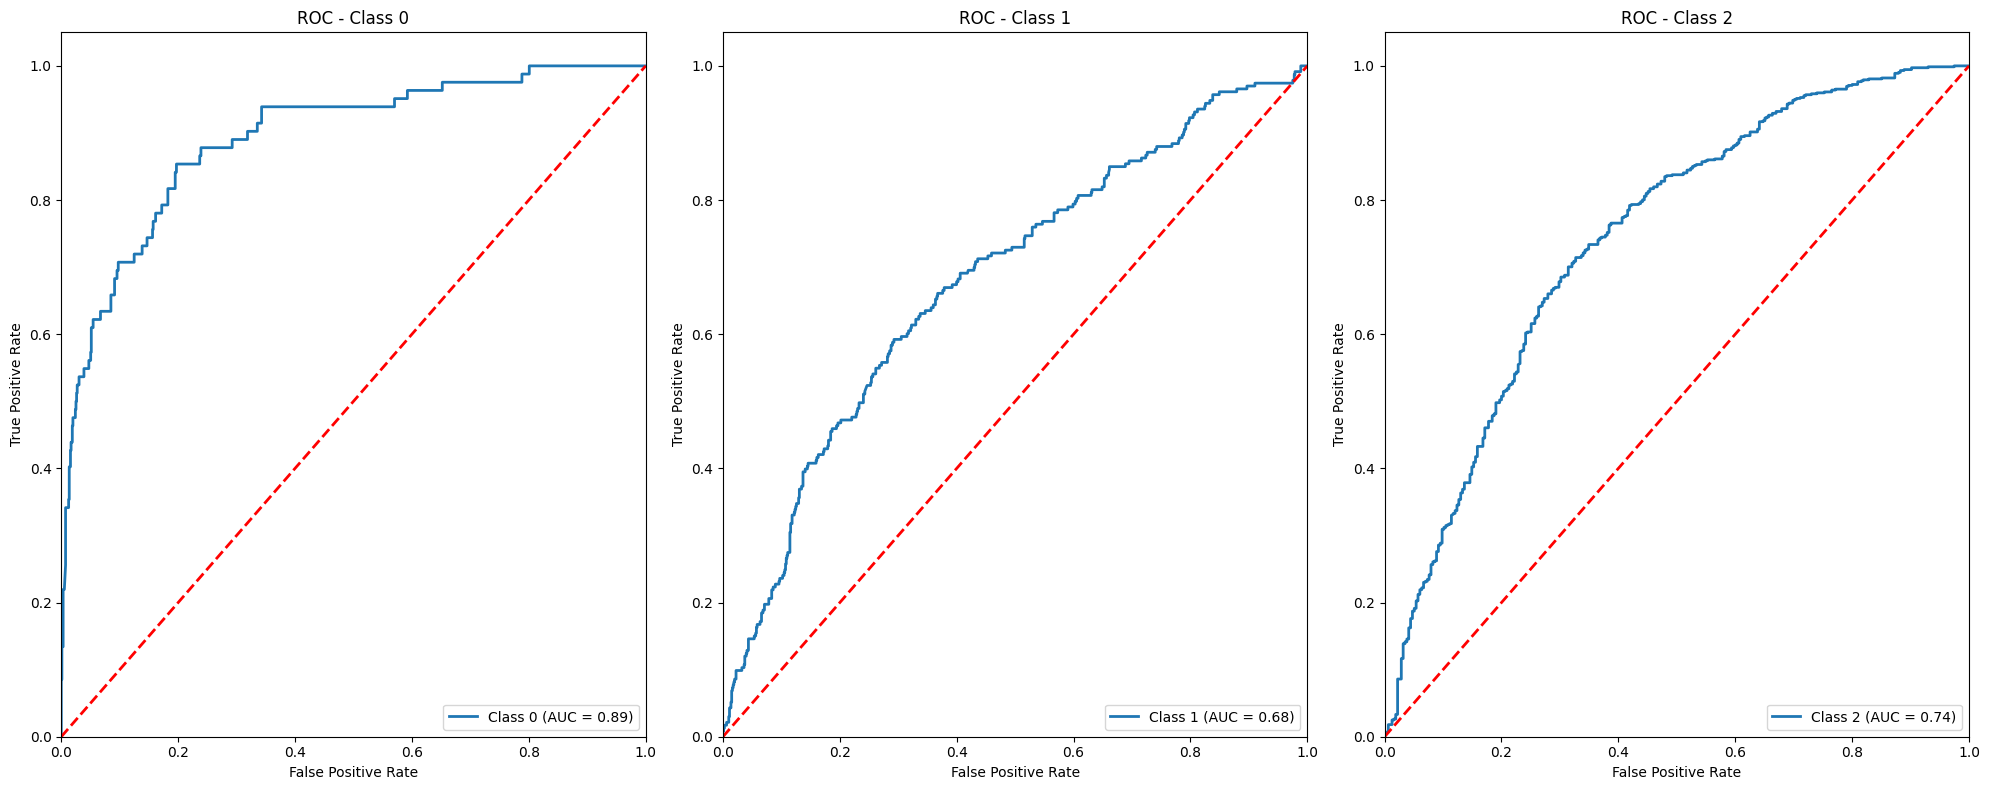

Confusion Matrix:



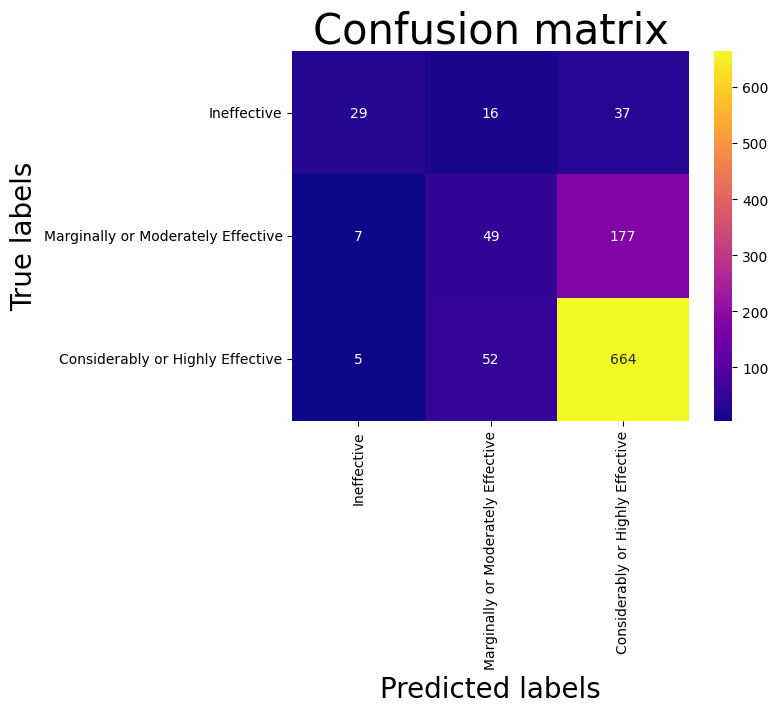

--------------------------------------------------
Training RNN model to predict sideEffects :
Epoch: 1/8 | Train Loss: 0.7934 | Train Acc: 0.6646 | Test Loss: 0.7072 | Test Acc: 0.7017
Epoch: 2/8 | Train Loss: 0.6871 | Train Acc: 0.7164 | Test Loss: 0.8331 | Test Acc: 0.6554
Epoch: 3/8 | Train Loss: 0.7453 | Train Acc: 0.6907 | Test Loss: 0.7408 | Test Acc: 0.6969
Epoch: 4/8 | Train Loss: 0.7292 | Train Acc: 0.6875 | Test Loss: 0.7723 | Test Acc: 0.6805
Epoch: 5/8 | Train Loss: 0.7237 | Train Acc: 0.6997 | Test Loss: 0.7569 | Test Acc: 0.6882
Epoch: 6/8 | Train Loss: 0.6955 | Train Acc: 0.7090 | Test Loss: 0.7394 | Test Acc: 0.6979
Epoch: 7/8 | Train Loss: 0.6638 | Train Acc: 0.7258 | Test Loss: 0.7370 | Test Acc: 0.7017
Epoch: 8/8 | Train Loss: 0.6441 | Train Acc: 0.7370 | Test Loss: 0.7154 | Test Acc: 0.7027
Loss and accuracy:


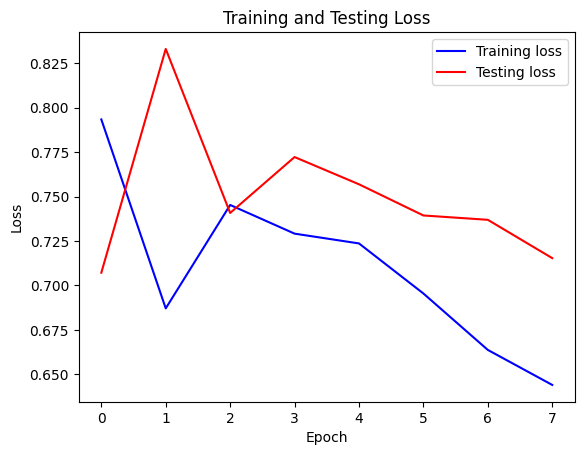

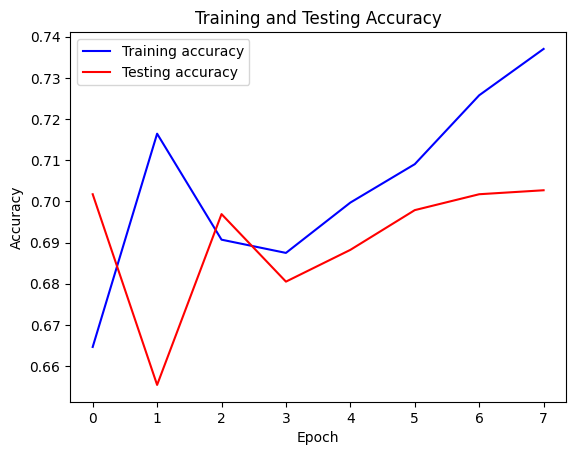

Other metrics:
--------------------------------------------------
Accuracy: 0.7027
Balanced Accuracy: 0.6401
Cohen’s kappa: 0.5293
F1 Score: 0.6981
Precision: 0.7024
Recall: 0.7027
Roc_auc_score: 0.8116
ROC AUC


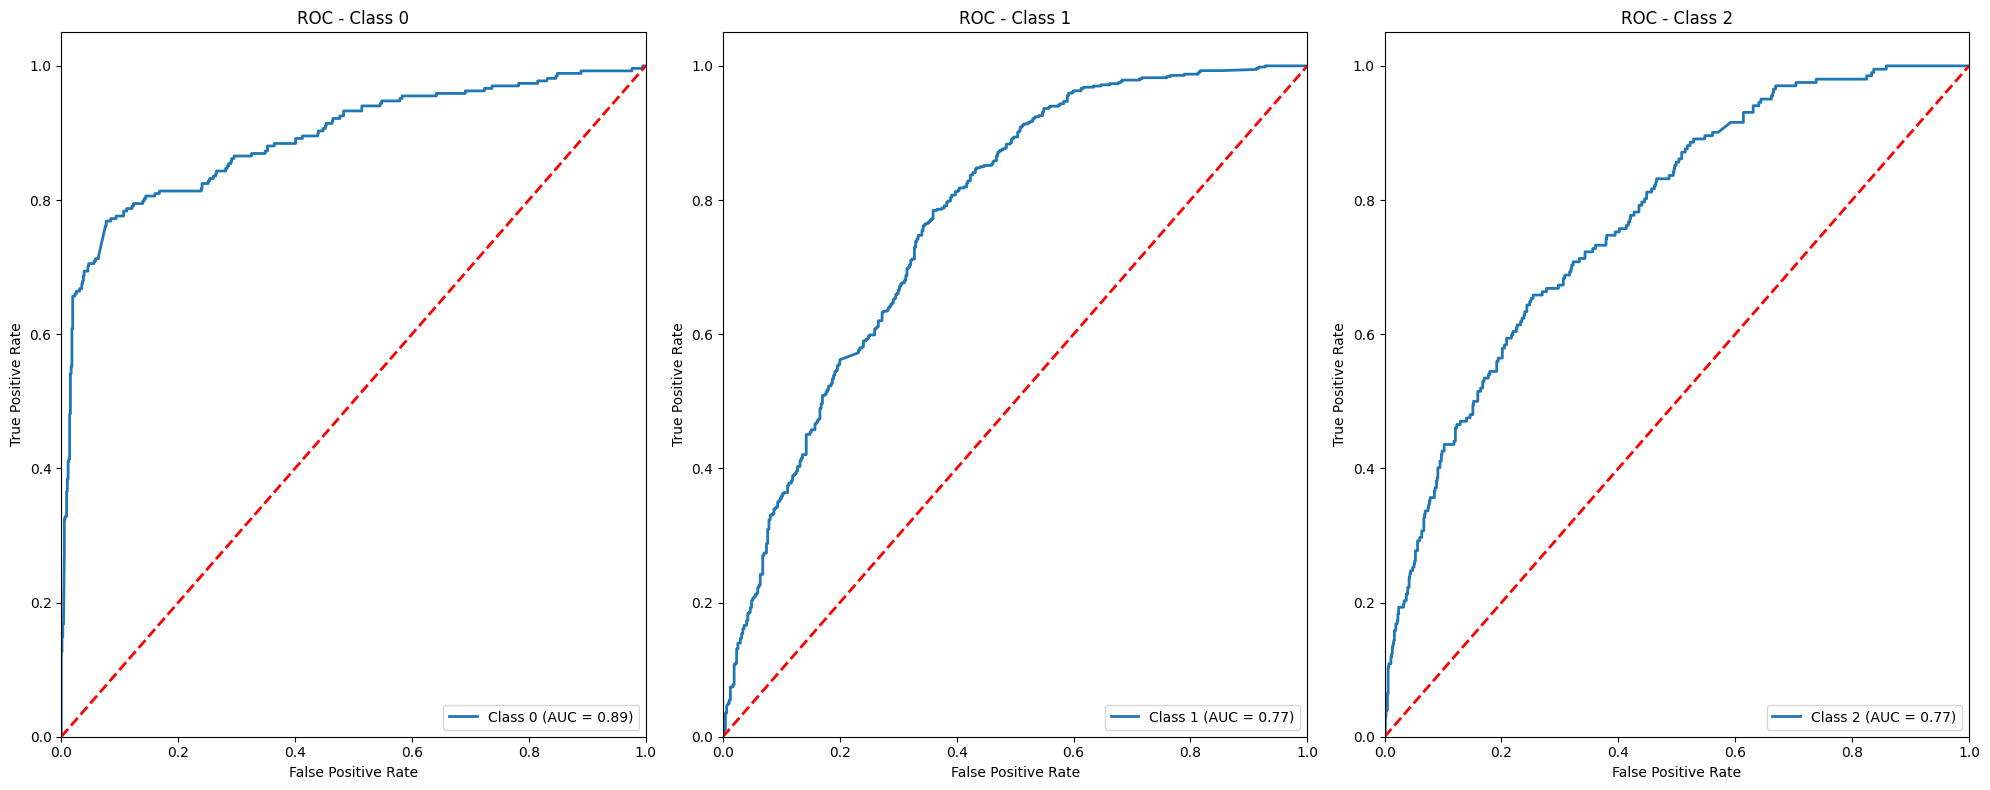

Confusion Matrix:



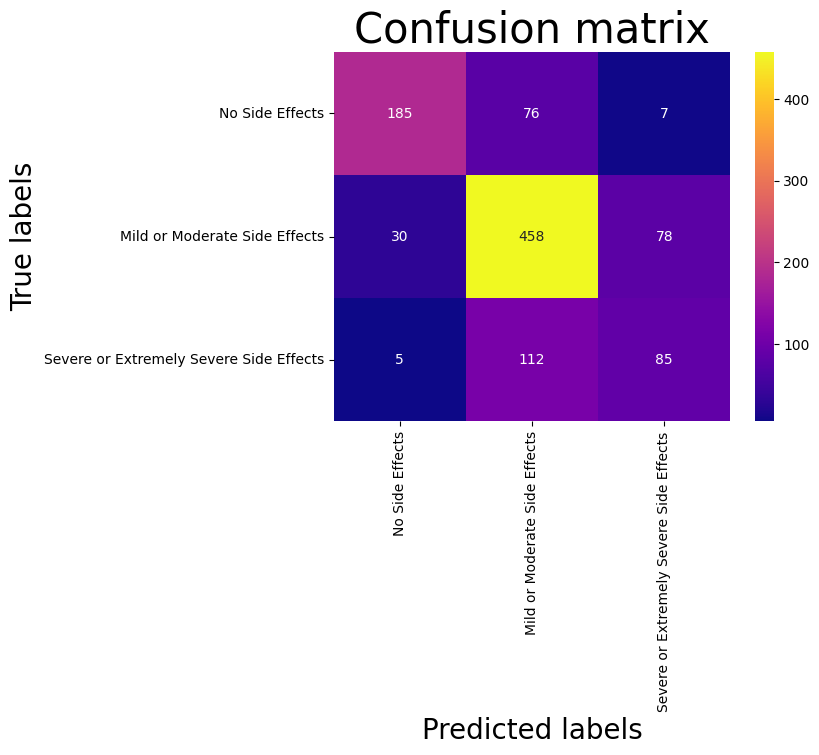

--------------------------------------------------
Training GRU model to predict sideEffects :
Epoch: 1/5 | Train Loss: 0.7312 | Train Acc: 0.6991 | Test Loss: 0.6616 | Test Acc: 0.7220
Epoch: 2/5 | Train Loss: 0.6193 | Train Acc: 0.7432 | Test Loss: 0.6152 | Test Acc: 0.7490
Epoch: 3/5 | Train Loss: 0.5631 | Train Acc: 0.7760 | Test Loss: 0.6250 | Test Acc: 0.7558
Epoch: 4/5 | Train Loss: 0.5307 | Train Acc: 0.7805 | Test Loss: 0.6584 | Test Acc: 0.7249
Epoch: 5/5 | Train Loss: 0.4868 | Train Acc: 0.8037 | Test Loss: 0.6198 | Test Acc: 0.7568
Loss and accuracy:


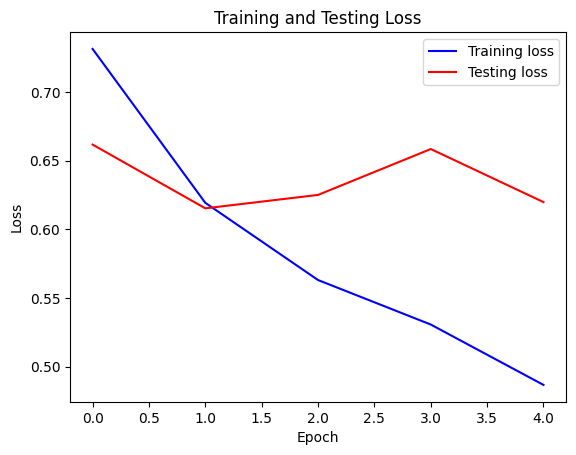

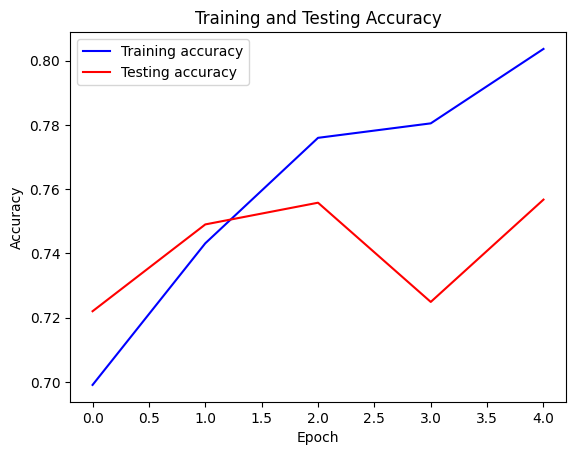

Other metrics:
--------------------------------------------------
Accuracy: 0.7568
Balanced Accuracy: 0.7104
Cohen’s kappa: 0.6196
F1 Score: 0.7543
Precision: 0.7571
Recall: 0.7568
Roc_auc_score: 0.8727
ROC AUC


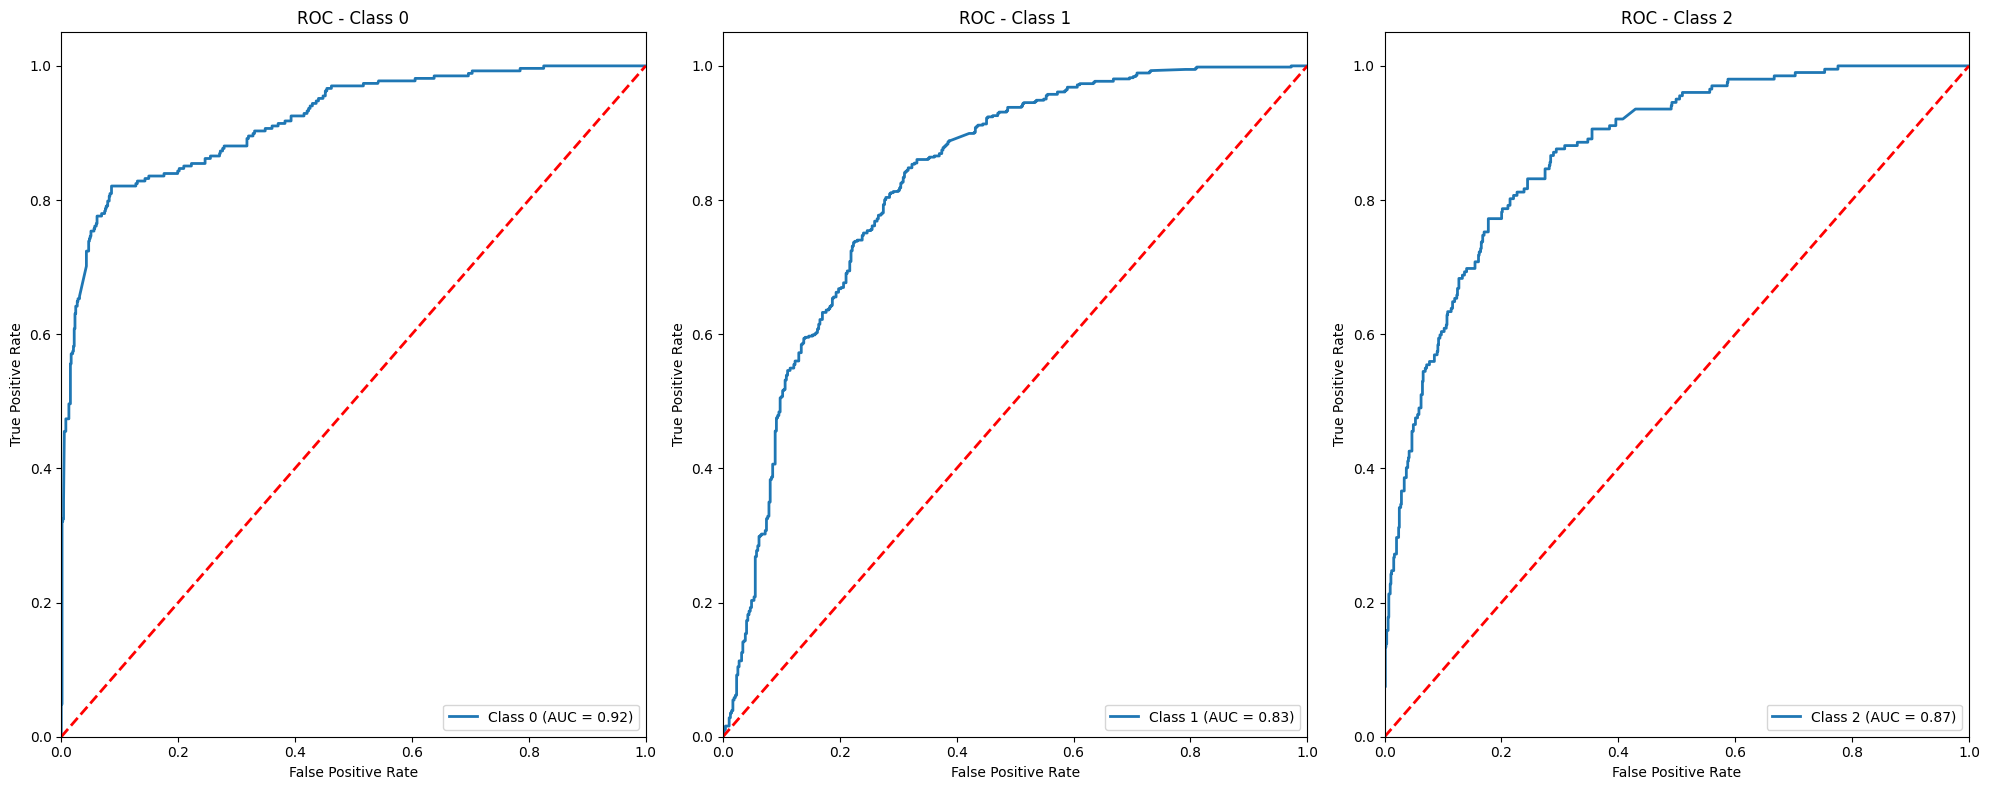

Confusion Matrix:



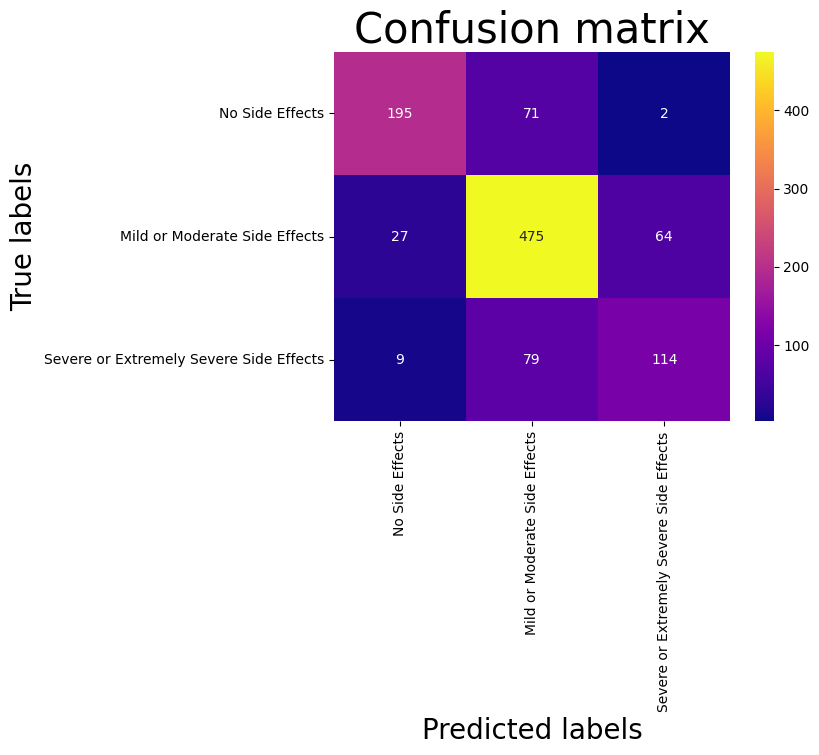

--------------------------------------------------
Training LSTM model to predict sideEffects :
Epoch: 1/5 | Train Loss: 0.7572 | Train Acc: 0.6833 | Test Loss: 0.7691 | Test Acc: 0.6998
Epoch: 2/5 | Train Loss: 0.6497 | Train Acc: 0.7419 | Test Loss: 0.6755 | Test Acc: 0.7297
Epoch: 3/5 | Train Loss: 0.5938 | Train Acc: 0.7596 | Test Loss: 0.6479 | Test Acc: 0.7384
Epoch: 4/5 | Train Loss: 0.5685 | Train Acc: 0.7676 | Test Loss: 0.6286 | Test Acc: 0.7481
Epoch: 5/5 | Train Loss: 0.5266 | Train Acc: 0.7908 | Test Loss: 0.6186 | Test Acc: 0.7510
Loss and accuracy:


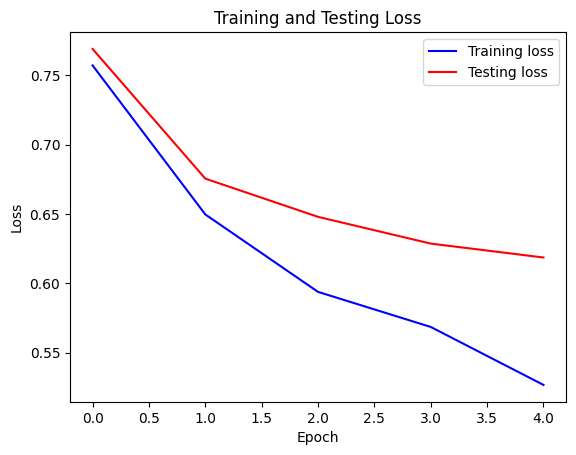

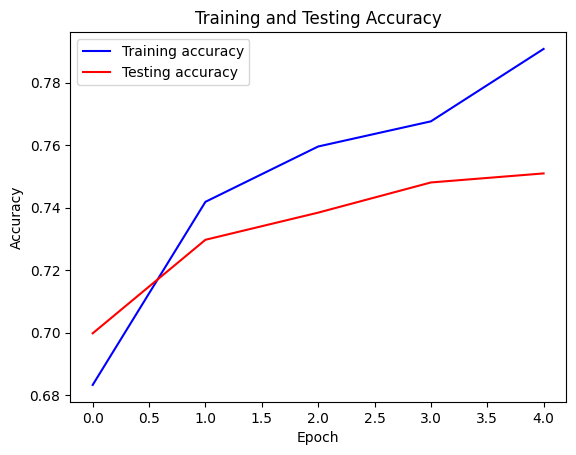

Other metrics:
--------------------------------------------------
Accuracy: 0.7510
Balanced Accuracy: 0.7201
Cohen’s kappa: 0.6205
F1 Score: 0.7513
Precision: 0.7532
Recall: 0.7510
Roc_auc_score: 0.8692
ROC AUC


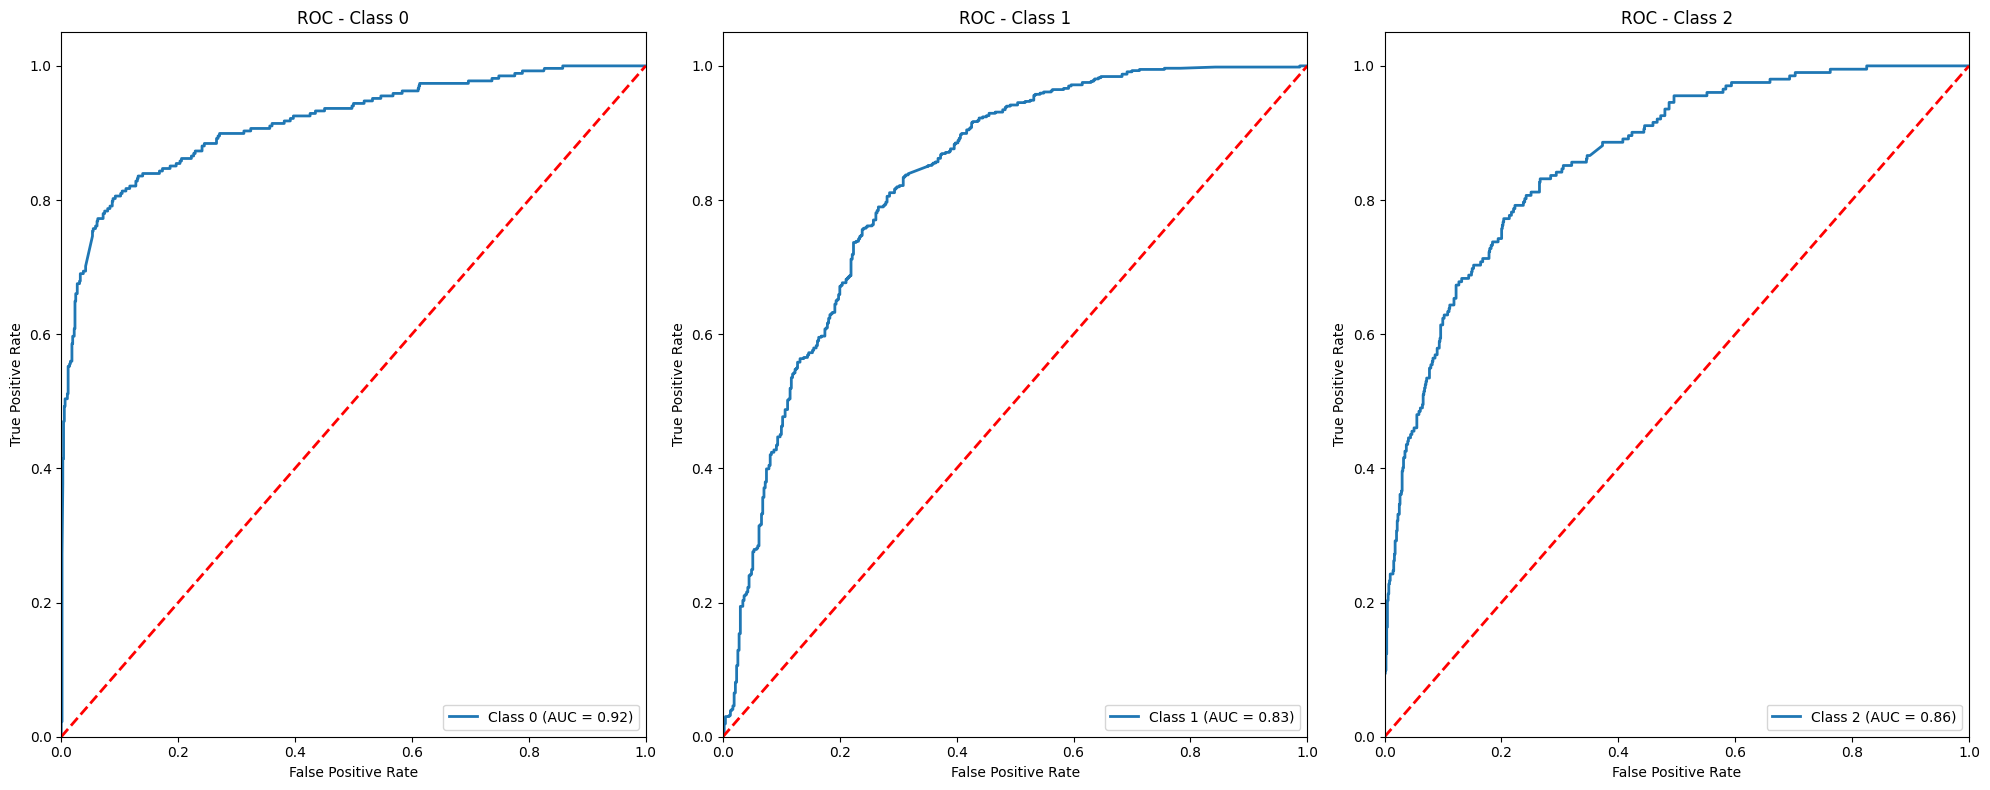

Confusion Matrix:



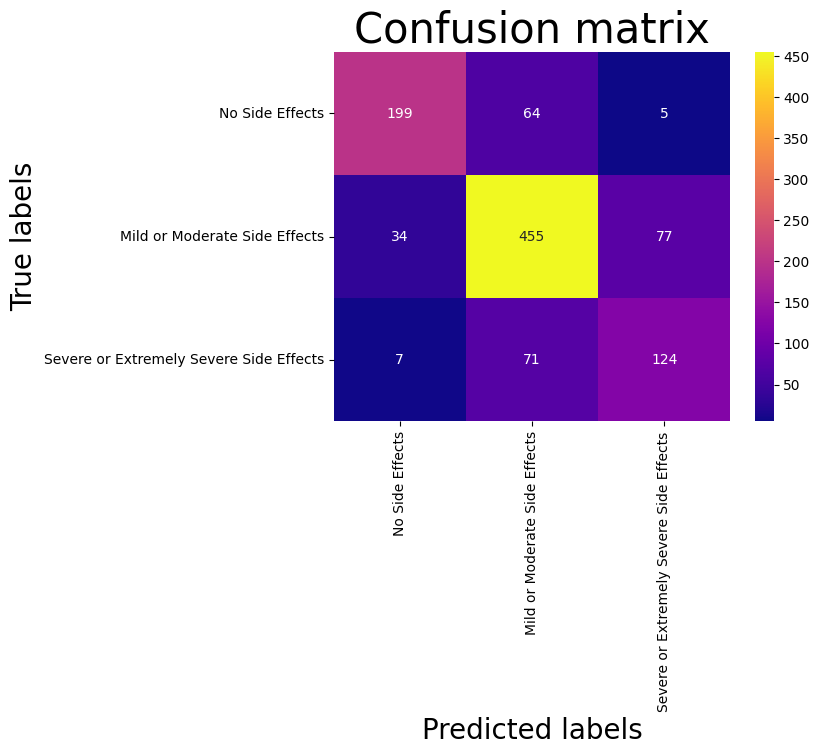

--------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model to predict sideEffects :
Epoch: 1/3 | Train Loss: 1.0123 | Train Acc: 0.5237 | Test Loss: 1.2257 | Test Acc: 0.2761
Epoch: 2/3 | Train Loss: 0.9904 | Train Acc: 0.5227 | Test Loss: 1.0299 | Test Acc: 0.5473
Epoch: 3/3 | Train Loss: 1.0100 | Train Acc: 0.5224 | Test Loss: 0.9290 | Test Acc: 0.5714
Loss and accuracy:


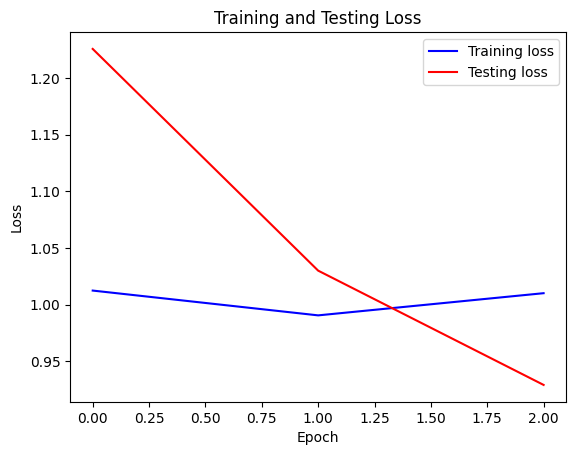

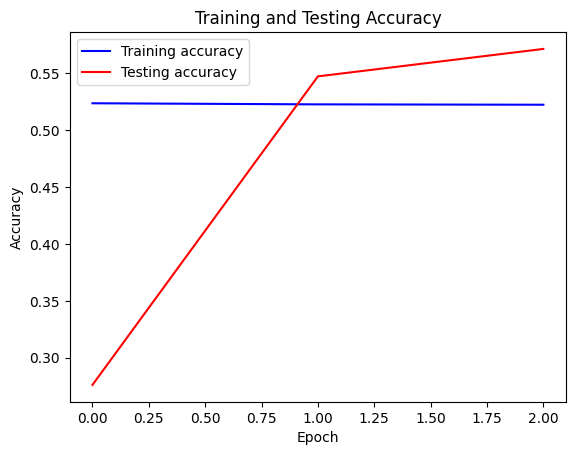

Other metrics:
--------------------------------------------------
Accuracy: 0.5714
Balanced Accuracy: 0.4110
Cohen’s kappa: 0.1668
F1 Score: 0.4990
Precision: 0.5553
Recall: 0.5714
Roc_auc_score: 0.6685
ROC AUC


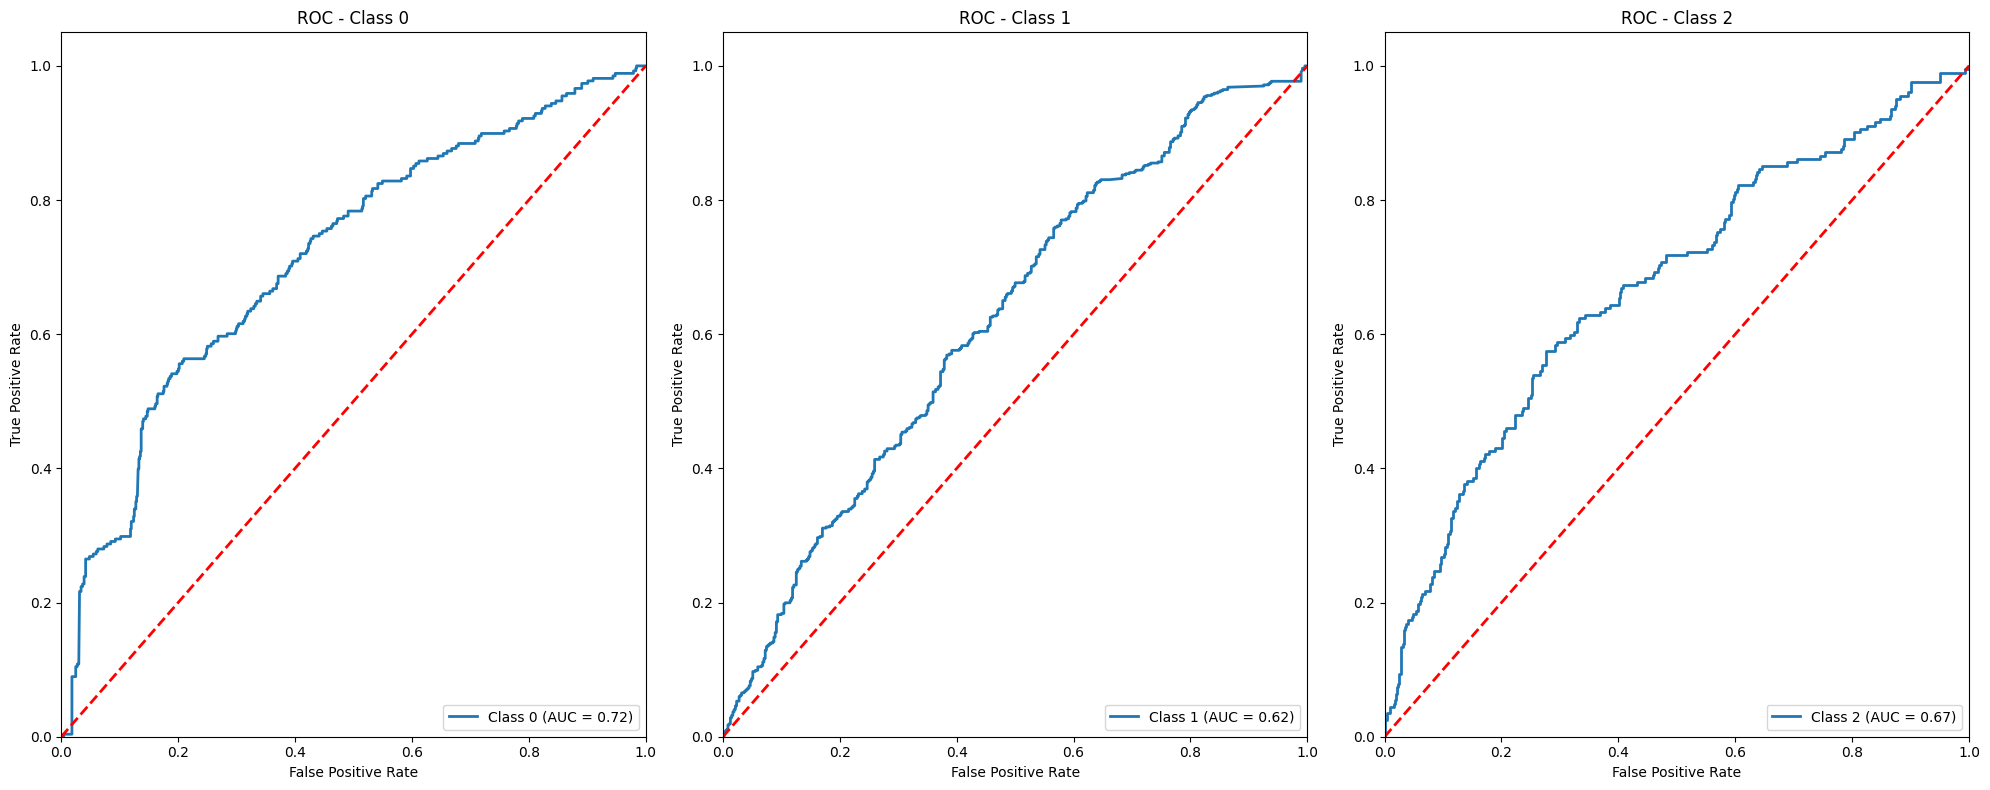

Confusion Matrix:



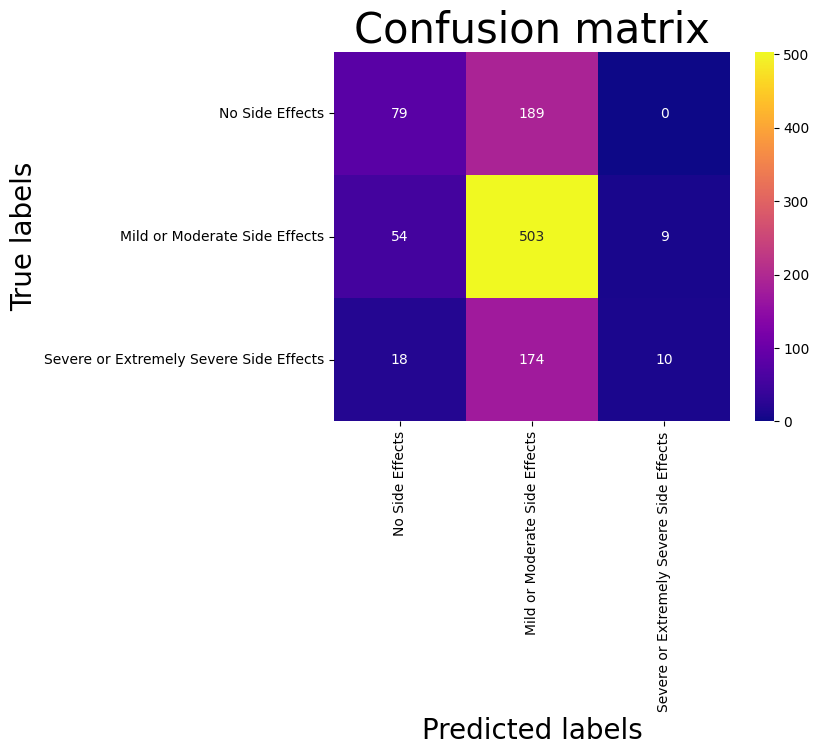

--------------------------------------------------


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training GPT model to predict sideEffects :
Epoch: 1/3 | Train Loss: 0.8328 | Train Acc: 0.6299 | Test Loss: 0.6895 | Test Acc: 0.7085
Epoch: 2/3 | Train Loss: 0.6879 | Train Acc: 0.7004 | Test Loss: 0.6612 | Test Acc: 0.7104
Epoch: 3/3 | Train Loss: 0.6502 | Train Acc: 0.7222 | Test Loss: 0.6601 | Test Acc: 0.7172
Loss and accuracy:


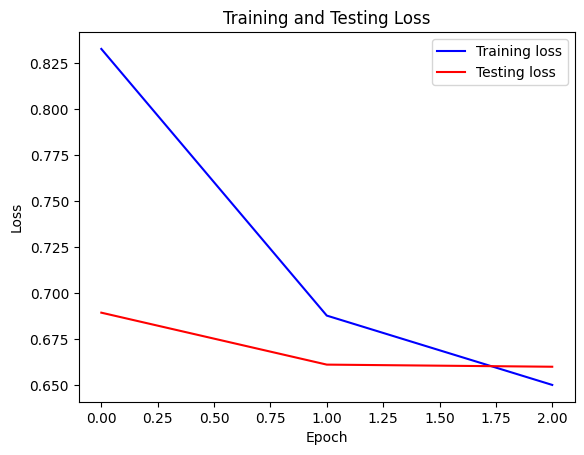

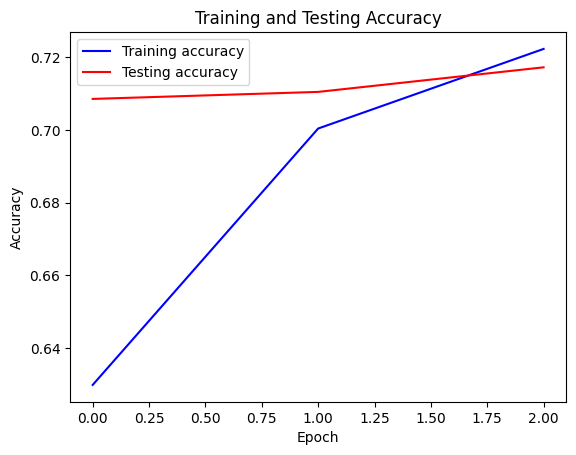

Other metrics:
--------------------------------------------------
Accuracy: 0.7172
Balanced Accuracy: 0.6651
Cohen’s kappa: 0.5527
F1 Score: 0.7082
Precision: 0.7121
Recall: 0.7172
Roc_auc_score: 0.859
ROC AUC


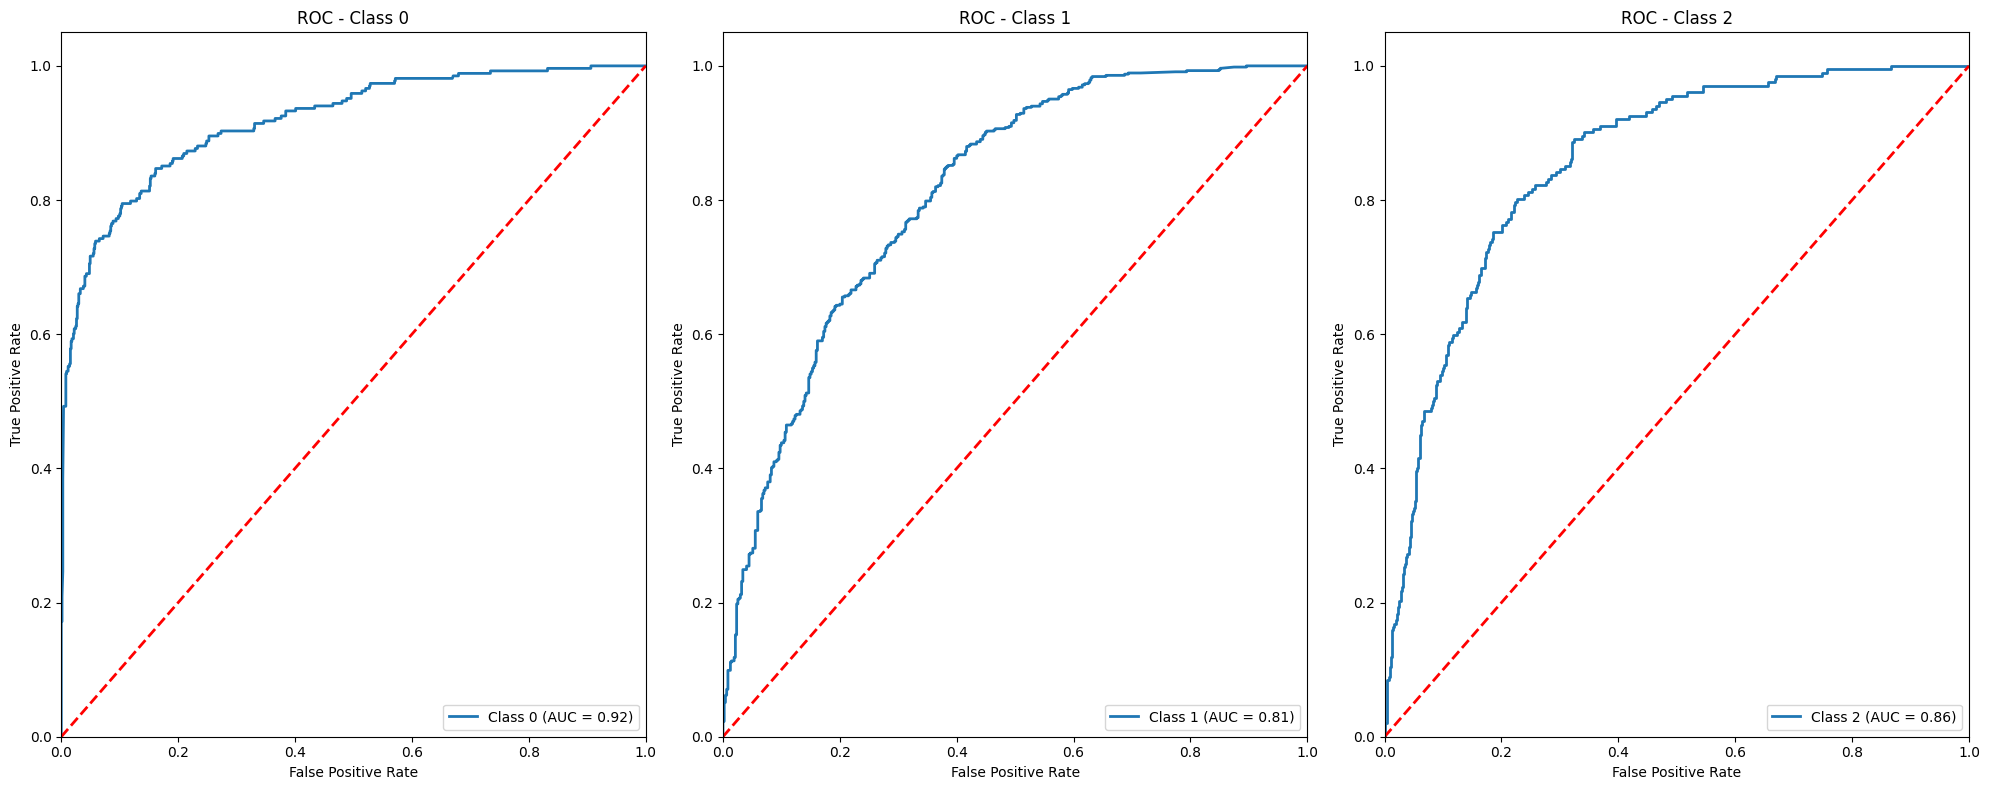

Confusion Matrix:



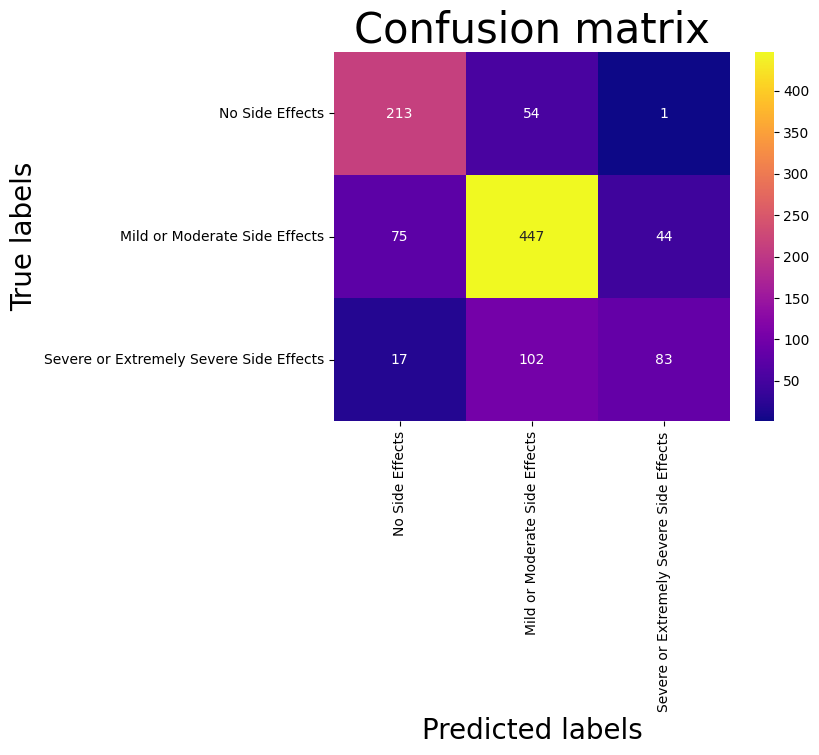

--------------------------------------------------


In [31]:
models = ['RNN', 'GRU', 'LSTM', 'BERT', 'GPT']
targets = ['rating', 'effectiveness', 'sideEffects']

for target in targets:
    for model in models:
        # очищаємо кеш GPU для ефективного використання ресурсів
        torch.cuda.empty_cache()
        run(model, target)

Можемо бачити, що для кожної таргет колонки вдалось досягнути точності, вказаної у статті. Щодо точності по рейтингу то середня категорія має найменшу точність через її розподіл, адже це лише 10% даних з тренувального набору. Найкраще себе проявили з рекурентних нейронних мереж LSTM та GRU, від них трішки відстала класична RNN. Звичайна RNN має схильність до проблеми зникаючих градієнтів (vanishing gradients). Коли ми намагаємося тренувати RNN на довгих послідовностях, може статися так, що градієнти, які передаються назад через час, стають дуже малими. LSTM та GRU мають механізми gating юнітів, які дозволяють контролювати, яка інформація повинна бути збережена або відкинута в кожному кроці часу. Це дозволяє побороти проблему зникання градієнтів. Щодо трансформерів, то GPT2 проявив себе краще ніж BERT. GPT-2 навчався на більшій кількості різноманітних даних та має більше параметрів ніж BERT. BERT зазвичай вимагає кращого налаштування параметрів для конкретної задачі, в той час як GPT-2 за замовчування показує дуже хороші результати, але GPT-2 вимагає більших обчислювальних ресурсів ніж Bert, що й було помітно під час навчання моделей.  